In [1]:
%%capture
!pip install ipyleaflet
!pip install ipyvolume
!pip install pyproj
!pip install shapely
!pip install pyvista
!pip install osmnx
!pip install open3d

In [2]:
import ipyleaflet
import IPython.display
import ipyvolume.pylab as p3
import pyproj
import shapely
from shapely.geometry import shape
from shapely.ops import transform
import math
import pyvista as pv
import numpy as np
import osmnx as ox
from shapely.geometry import Polygon, Point, LineString
import os
from pyproj import Transformer
import open3d as o3d
import xml.etree.ElementTree as ET
import xml.dom.minidom as minidom

In [3]:
from google.colab import output
output.enable_custom_widget_manager()
print("✅ Custom widget support enabled")

✅ Custom widget support enabled


In [4]:

center_lat = 14.557097311312177
center_lon = 121.02000072883868
LOCATION_STR = "PHILLIPINES"

spp_default = 4096
resx_default = 1024
resy_default = 768

camera_settings = {
    "rotation": (0, 0, -90),
    "fov": 42.854885
}

material_colors = {
    "mat-itu_concrete": (0.539479, 0.539479, 0.539480),
    "mat-itu_marble": (0.701101, 0.644479, 0.485150),
    "mat-itu_metal": (0.219526, 0.219526, 0.254152),
    "mat-itu_wood": (0.043, 0.58, 0.184),
    "mat-itu_wet_ground": (0.91,0.569,0.055),
}

print("✅ Parameters initialized")

✅ Parameters initialized


In [5]:

def create_map():
    m = ipyleaflet.Map(center=(center_lat, center_lon), zoom=16)
    draw_control = ipyleaflet.DrawControl()
    draw_control.polygon = {
        "shapeOptions": {
            "color": "#ff0000",
            "fillOpacity": 0.2
        }
    }
    m.add_control(draw_control)
    return m, draw_control

m, dc = create_map()

# Display the map
display(m)

print("\n📍 Instructions for drawing area:")
print("1. Click the polygon tool (square icon) in the map's top right corner")
print("2. Click points on the map to draw your area of interest")
print("3. Complete the polygon by clicking the first point again")
print("4. After drawing, run the 'Process Selected Region' cell")

Map(center=[14.557097311312177, 121.02000072883868], controls=(ZoomControl(options=['position', 'zoom_in_text'…


📍 Instructions for drawing area:
1. Click the polygon tool (square icon) in the map's top right corner
2. Click points on the map to draw your area of interest
3. Complete the polygon by clicking the first point again
4. After drawing, run the 'Process Selected Region' cell


In [16]:
def process_selected_region():
    try:
        if not dc.last_draw:
            print("❌ No area drawn yet. Please draw an area first.")
            return None

        wsg84 = pyproj.CRS("epsg:4326")
        lambert = pyproj.CRS("epsg:26915")
        transformer = pyproj.Transformer.from_crs(wsg84, lambert, always_xy=True)

        coords = [transformer.transform(x, y)
                 for x, y in dc.last_draw['geometry']['coordinates'][0]]


        aoi_polygon = shapely.geometry.Polygon(coords)


        global center_x, center_y
        center_x = aoi_polygon.centroid.x
        center_y = aoi_polygon.centroid.y

        global LOCATION_DIR
        LOCATION_DIR = f"{LOCATION_STR}_{center_x}_{center_y}"


        os.makedirs(f"simple_scene/{LOCATION_DIR}/mesh", exist_ok=True)

        print(f"✅ Area successfully processed!")
        print(f"📍 Center: ({center_x:.6f}, {center_y:.6f})")
        print(f"📁 Directory: simple_scene/{LOCATION_DIR}")

        return aoi_polygon

    except Exception as e:
        print(f"❌ Error: {str(e)}")
        print("Please try drawing the area again.")
        return None

aoi_polygon = process_selected_region()
if aoi_polygon is not None:
    print(f"📐 Area: {aoi_polygon.area:.2f} square meters")

✅ Area successfully processed!
📍 Center: (-3367488.049735, 18070065.270090)
📁 Directory: simple_scene/PHILLIPINES_-3367488.04973535_18070065.270089604
📐 Area: 43504.05 square meters


In [17]:

scene = ET.Element("scene", version="2.1.0")

ET.SubElement(scene, "default", name="spp", value=str(spp_default))
ET.SubElement(scene, "default", name="resx", value=str(resx_default))
ET.SubElement(scene, "default", name="resy", value=str(resy_default))

integrator = ET.SubElement(scene, "integrator", type="path")
ET.SubElement(integrator, "integer", name="max_depth", value="12")

for material_id, rgb in material_colors.items():
    bsdf_twosided = ET.SubElement(scene, "bsdf", type="twosided", id=material_id)
    bsdf_diffuse = ET.SubElement(bsdf_twosided, "bsdf", type="diffuse")
    ET.SubElement(bsdf_diffuse, "rgb", value=f"{rgb[0]} {rgb[1]} {rgb[2]}", name="reflectance")

print("✅ Scene XML initialized")

✅ Scene XML initialized


In [18]:
%%capture
!pip uninstall -y tensorflow tensorflow-gpu numpy sionna
!pip install numpy==1.23.5
!pip install tensorflow==2.12.0
!pip install sionna

In [19]:
try:
    import numpy as np
    print(f"NumPy version: {np.__version__}")

    import tensorflow as tf
    print(f"TensorFlow version: {tf.__version__}")

    import sionna
    from sionna.rt import Scene, load_scene
    print(f"Sionna version: {sionna.__version__}")

    print("✅ All libraries imported successfully")
except Exception as e:
    print(f"❌ Error importing libraries: {str(e)}")
    print("\nTroubleshooting steps:")
    print("1. Make sure to restart the runtime after installing packages")
    print("2. Check if all packages were installed correctly")
    print("3. Try running the installation cell again if needed")

NumPy version: 1.26.4
TensorFlow version: 2.19.0
Sionna version: 1.0.1
✅ All libraries imported successfully


In [20]:
!pip install meshio


Warning: PLY doesn't support 64-bit integers. Casting down to 32-bit.

✅ Ground mesh created and added to scene


Starting building processing...
Processed 10 buildings...
Processed 20 buildings...
✅ Successfully processed 20 buildings


In [24]:
#@title Process Buildings with Correct Transformer Usage
import numpy as np
import os
from shapely.ops import transform

def save_sionna_ply(vertices, faces, filepath):
    """
    Save mesh in PLY format specifically compatible with Sionna
    Args:
        vertices: numpy array of shape (N, 3) containing vertex coordinates
        faces: numpy array of shape (M, 3) containing face indices
        filepath: path to save the PLY file
    """
    # Convert vertices and faces to numpy arrays if they aren't already
    vertices = np.array(vertices)
    faces = np.array(faces)

    # Create header
    header = [
        "ply",
        "format ascii 1.0",
        f"element vertex {len(vertices)}",
        "property float x",
        "property float y",
        "property float z",
        f"element face {len(faces)}",
        "property list uchar int vertex_index",
        "end_header"
    ]

    # Write file
    with open(filepath, 'w') as f:
        # Write header
        f.write('\n'.join(header) + '\n')

        # Write vertices
        for v in vertices:
            f.write(f"{v[0]} {v[1]} {v[2]}\n")

        # Write faces
        for face in faces:
            f.write(f"3 {face[0]} {face[1]} {face[2]}\n")

def process_buildings(aoi_polygon):
    try:
        # Set up coordinate transformations
        lambert = pyproj.CRS("epsg:26915")
        wgs84 = pyproj.CRS("epsg:4326")

        # Create transformers
        to_wgs84 = pyproj.Transformer.from_crs(lambert, wgs84, always_xy=True)
        to_lambert = pyproj.Transformer.from_crs(wgs84, lambert, always_xy=True)

        # Convert aoi_polygon to WGS84
        aoi_polygon_wgs84 = transform(
            lambda x, y: to_wgs84.transform(x, y),
            aoi_polygon
        )

        # Get buildings from OpenStreetMap
        tags = {'building': True}
        buildings = ox.features_from_polygon(aoi_polygon_wgs84, tags=tags)

        if buildings is None or buildings.empty:
            print("No buildings found in the selected area")
            return

        filtered_buildings = buildings[buildings.intersects(aoi_polygon_wgs84)]
        buildings_list = filtered_buildings.to_dict('records')

        # Ensure mesh directory exists
        mesh_dir = f"simple_scene/{LOCATION_DIR}/mesh"
        os.makedirs(mesh_dir, exist_ok=True)

        building_count = 0

        # Process ground first
        ground_vertices = []
        ground_faces = []
        for coord in aoi_polygon.exterior.coords[:-1]:
            ground_vertices.append([coord[0]-center_x, coord[1]-center_y, 0])

        # Triangulate ground (simple fan triangulation)
        for i in range(1, len(ground_vertices)-1):
            ground_faces.append([0, i, i+1])

        # Save ground mesh
        save_sionna_ply(ground_vertices, ground_faces, f"{mesh_dir}/ground.ply")

        # Add ground to scene
        sionna_shape = ET.SubElement(scene, "shape", type="ply", id="mesh-ground")
        ET.SubElement(sionna_shape, "string", name="filename",
                     value=f"{mesh_dir}/ground.ply")
        ET.SubElement(sionna_shape, "ref", id="mat-itu_wet_ground", name="bsdf")

        print("✅ Ground mesh created")

        # Process buildings
        for idx, building in enumerate(buildings_list):
            try:
                # Process building geometry
                building_polygon = shape(building['geometry'])
                if building_polygon.geom_type != 'Polygon':
                    continue

                # Transform building polygon to Lambert projection
                building_polygon_lambert = transform(
                    lambda x, y: to_lambert.transform(x, y),
                    building_polygon
                )

                levels = float(building.get('building:levels', '1'))
                building_height = levels * 3.5

                # Create vertices and faces for building
                vertices = []
                faces = []

                # Bottom vertices
                bottom_vertices = []
                for coord in building_polygon_lambert.exterior.coords[:-1]:
                    x, y = coord[0]-center_x, coord[1]-center_y
                    vertices.append([x, y, 0])
                    bottom_vertices.append(len(vertices)-1)

                # Top vertices
                top_vertices = []
                for coord in building_polygon_lambert.exterior.coords[:-1]:
                    x, y = coord[0]-center_x, coord[1]-center_y
                    vertices.append([x, y, building_height])
                    top_vertices.append(len(vertices)-1)

                # Create faces
                # Bottom face
                for i in range(1, len(bottom_vertices)-1):
                    faces.append([bottom_vertices[0], bottom_vertices[i], bottom_vertices[i+1]])

                # Top face
                for i in range(1, len(top_vertices)-1):
                    faces.append([top_vertices[0], top_vertices[i+1], top_vertices[i]])

                # Side faces
                for i in range(len(bottom_vertices)):
                    j = (i + 1) % len(bottom_vertices)
                    faces.append([bottom_vertices[i], top_vertices[i], bottom_vertices[j]])
                    faces.append([bottom_vertices[j], top_vertices[i], top_vertices[j]])

                # Save building mesh
                mesh_path = f"{mesh_dir}/building_{idx}.ply"
                save_sionna_ply(vertices, faces, mesh_path)

                # Add to scene
                sionna_shape = ET.SubElement(scene, "shape", type="ply",
                                           id=f"mesh-building_{idx}")
                ET.SubElement(sionna_shape, "string", name="filename",
                             value=mesh_path)
                ET.SubElement(sionna_shape, "ref", id="mat-itu_marble", name="bsdf")

                building_count += 1
                if building_count % 10 == 0:
                    print(f"Processed {building_count} buildings...")

            except Exception as building_error:
                print(f"Warning: Skipped building {idx} due to: {str(building_error)}")
                continue

        print(f"✅ Successfully processed {building_count} buildings")

    except Exception as e:
        print(f"❌ Error processing buildings: {str(e)}")
        raise

# Process buildings if area is selected
if aoi_polygon is not None:
    print("Starting building processing...")
    process_buildings(aoi_polygon)
else:
    print("❌ No area selected. Please process a region first.")

Starting building processing...
✅ Ground mesh created
Processed 10 buildings...
Processed 20 buildings...
✅ Successfully processed 20 buildings


In [25]:
#@title Process Buildings with Strict PLY Format
import numpy as np
import os

def save_sionna_ply_strict(vertices, faces, filepath):
    """
    Save mesh in strictly formatted PLY file for Sionna
    """
    try:
        vertices = np.array(vertices, dtype=np.float32)  # Ensure float32 precision
        faces = np.array(faces, dtype=np.int32)  # Ensure int32 precision

        # Create header with exact format
        header = [
            "ply",
            "format ascii 1.0",
            f"element vertex {len(vertices)}",
            "property float32 x",
            "property float32 y",
            "property float32 z",
            f"element face {len(faces)}",
            "property list uchar int vertex_index",
            "end_header"
        ]

        with open(filepath, 'w') as f:
            # Write header
            f.write('\n'.join(header) + '\n')

            # Write vertices with controlled precision
            for v in vertices:
                f.write(f"{v[0]:.6f} {v[1]:.6f} {v[2]:.6f}\n")

            # Write faces
            for face in faces:
                f.write(f"3 {face[0]} {face[1]} {face[2]}\n")

        return True
    except Exception as e:
        print(f"Error saving PLY file {filepath}: {str(e)}")
        return False

def process_buildings_strict(aoi_polygon):
    try:
        # Set up coordinate transformations
        lambert = pyproj.CRS("epsg:26915")
        wgs84 = pyproj.CRS("epsg:4326")
        to_wgs84 = pyproj.Transformer.from_crs(lambert, wgs84, always_xy=True)
        to_lambert = pyproj.Transformer.from_crs(wgs84, lambert, always_xy=True)

        # Convert aoi_polygon to WGS84
        aoi_polygon_wgs84 = transform(
            lambda x, y: to_wgs84.transform(x, y),
            aoi_polygon
        )

        # Get buildings
        tags = {'building': True}
        buildings = ox.features_from_polygon(aoi_polygon_wgs84, tags=tags)

        if buildings is None or buildings.empty:
            print("No buildings found in the selected area")
            return

        # Ensure mesh directory exists
        mesh_dir = f"simple_scene/{LOCATION_DIR}/mesh"
        os.makedirs(mesh_dir, exist_ok=True)

        # Process ground first
        ground_vertices = []
        ground_faces = []

        # Create ground mesh with exact values
        coords = list(aoi_polygon.exterior.coords)[:-1]  # Exclude last point
        for coord in coords:
            ground_vertices.append([
                float(coord[0]-center_x),
                float(coord[1]-center_y),
                0.0
            ])

        # Create ground faces
        for i in range(1, len(coords)-1):
            ground_faces.append([0, i, i+1])

        # Save ground mesh
        ground_path = f"{mesh_dir}/ground.ply"
        if not save_sionna_ply_strict(ground_vertices, ground_faces, ground_path):
            raise Exception("Failed to save ground mesh")

        print("✅ Ground mesh created")

        # Process buildings
        building_count = 0
        for idx, building in enumerate(buildings.itertuples()):
            try:
                if not hasattr(building, 'geometry') or building.geometry.geom_type != 'Polygon':
                    continue

                # Transform building to Lambert projection
                building_polygon = transform(
                    lambda x, y: to_lambert.transform(x, y),
                    building.geometry
                )

                # Get building height
                levels = float(getattr(building, 'building:levels', 1))
                building_height = float(levels * 3.5)  # Ensure float

                # Create building vertices
                vertices = []
                faces = []

                # Get coordinates and ensure they're proper floats
                coords = list(building_polygon.exterior.coords)[:-1]
                bottom_vertices = []
                top_vertices = []

                # Create vertices
                for coord in coords:
                    x = float(coord[0] - center_x)
                    y = float(coord[1] - center_y)

                    # Bottom vertex
                    bottom_vertices.append(len(vertices))
                    vertices.append([x, y, 0.0])

                    # Top vertex
                    top_vertices.append(len(vertices))
                    vertices.append([x, y, float(building_height)])

                # Create faces
                # Bottom face
                for i in range(1, len(bottom_vertices)-1):
                    faces.append([
                        bottom_vertices[0],
                        bottom_vertices[i],
                        bottom_vertices[i+1]
                    ])

                # Top face
                for i in range(1, len(top_vertices)-1):
                    faces.append([
                        top_vertices[0],
                        top_vertices[i+1],
                        top_vertices[i]
                    ])

                # Side faces
                for i in range(len(bottom_vertices)):
                    j = (i + 1) % len(bottom_vertices)
                    faces.append([
                        bottom_vertices[i],
                        top_vertices[i],
                        bottom_vertices[j]
                    ])
                    faces.append([
                        bottom_vertices[j],
                        top_vertices[i],
                        top_vertices[j]
                    ])

                # Save building mesh
                building_path = f"{mesh_dir}/building_{idx}.ply"
                if save_sionna_ply_strict(vertices, faces, building_path):
                    building_count += 1
                    if building_count % 10 == 0:
                        print(f"Processed {building_count} buildings...")

            except Exception as building_error:
                print(f"Warning: Skipped building {idx} due to: {str(building_error)}")
                continue

        print(f"✅ Successfully processed {building_count} buildings")
        return True

    except Exception as e:
        print(f"❌ Error processing buildings: {str(e)}")
        return False

# Process buildings
if aoi_polygon is not None:
    print("Starting building processing...")
    if process_buildings_strict(aoi_polygon):
        print("✅ All buildings processed successfully")
    else:
        print("❌ Error during building processing")

Starting building processing...
✅ Ground mesh created
Processed 10 buildings...
Processed 20 buildings...
✅ Successfully processed 20 buildings
✅ All buildings processed successfully


In [26]:
#@title Save and Load Scene in Sionna with Strict Validation
def verify_ply_file(filepath):
    """Verify PLY file format"""
    try:
        with open(filepath, 'r') as f:
            header = f.readline().strip()
            if header != "ply":
                return False

            # Read a few vertices to verify format
            in_vertex = False
            vertex_count = 0

            for line in f:
                line = line.strip()
                if line == "end_header":
                    in_vertex = True
                    continue

                if in_vertex:
                    # Try parsing vertex coordinates
                    try:
                        x, y, z = map(float, line.split())
                        vertex_count += 1
                        if vertex_count >= 3:  # Check first 3 vertices
                            return True
                    except:
                        return False
        return True
    except:
        return False

def save_scene_with_validation():
    """Save scene with PLY file validation"""
    try:
        # Clean existing shapes
        clean_scene()

        mesh_dir = f"simple_scene/{LOCATION_DIR}/mesh"

        # Verify ground mesh
        ground_path = f"{mesh_dir}/ground.ply"
        if not verify_ply_file(ground_path):
            raise Exception(f"Invalid ground mesh format: {ground_path}")

        # Add ground to scene
        ground_id = "mesh-ground-main"
        sionna_shape = ET.SubElement(scene, "shape", type="ply", id=ground_id)
        ET.SubElement(sionna_shape, "string", name="filename", value=ground_path)
        ET.SubElement(sionna_shape, "ref", id="mat-itu_wet_ground", name="bsdf")

        # Process building meshes
        building_files = sorted([f for f in os.listdir(mesh_dir)
                               if f.startswith('building_')])

        for building_file in building_files:
            # Verify building mesh
            building_path = os.path.join(mesh_dir, building_file)
            if not verify_ply_file(building_path):
                print(f"Warning: Skipping invalid building mesh: {building_file}")
                continue

            building_id = f"mesh-{os.path.splitext(building_file)[0]}"
            sionna_shape = ET.SubElement(scene, "shape", type="ply", id=building_id)
            ET.SubElement(sionna_shape, "string", name="filename", value=building_path)
            ET.SubElement(sionna_shape, "ref", id="mat-itu_marble", name="bsdf")

        # Save scene XML
        scene_path = f"simple_scene/{LOCATION_DIR}/simple_OSM_scene.xml"
        tree = ET.ElementTree(scene)
        xml_string = ET.tostring(scene, encoding="utf-8")
        xml_pretty = minidom.parseString(xml_string).toprettyxml(indent="    ")

        # Clean up XML
        xml_lines = [line for line in xml_pretty.split('\n') if line.strip()]
        xml_clean = '\n'.join(xml_lines)

        with open(scene_path, "w", encoding="utf-8") as xml_file:
            xml_file.write(xml_clean)

        return scene_path

    except Exception as e:
        raise Exception(f"Error saving scene: {str(e)}")

try:
    # Save and validate scene
    scene_path = save_scene_with_validation()
    print("✅ Scene XML saved successfully")

    # Load scene in Sionna
    sionna_scene = load_scene(scene_path)
    print("✅ Scene loaded in Sionna successfully")

    # Display scene info
    print("\n📊 Scene Information:")
    print(f"Number of objects: {len(sionna_scene.objects)}")
    print(f"Scene bounds: {sionna_scene.bounds}")

except Exception as e:
    print(f"❌ Error saving/loading scene: {str(e)}")
    print("\nTroubleshooting steps:")
    print("1. Check PLY files:")
    print(f"   - Directory: simple_scene/{LOCATION_DIR}/mesh")
    print("   - Verify file permissions and format")

    # Try to read problematic PLY file
    if "building_" in str(e):
        try:
            file_name = str(e).split('"')[1]
            file_path = os.path.join(f"simple_scene/{LOCATION_DIR}/mesh", file_name)
            with open(file_path, 'r') as f:
                print("\nPLY file content (first 10 lines):")
                print('\n'.join(f.readlines()[:10]))
        except:
            print("Could not read PLY file content")

❌ Error saving/loading scene: Error saving scene: name 'clean_scene' is not defined

Troubleshooting steps:
1. Check PLY files:
   - Directory: simple_scene/PHILLIPINES_-3367488.04973535_18070065.270089604/mesh
   - Verify file permissions and format


In [27]:
#@title Save and Load Scene in Sionna with Scene Information
def get_scene_info(sionna_scene):
    """Get detailed information about the Sionna scene"""
    try:
        info = {
            "object_count": len(sionna_scene.objects),
            "mesh_count": sum(1 for obj in sionna_scene.objects if hasattr(obj, 'mesh')),
            "material_count": len(set(obj.material for obj in sionna_scene.objects if hasattr(obj, 'material'))),
        }

        # Try to get scene dimensions if available
        try:
            vertices = []
            for obj in sionna_scene.objects:
                if hasattr(obj, 'mesh') and hasattr(obj.mesh, 'vertices'):
                    vertices.extend(obj.mesh.vertices)

            if vertices:
                vertices = np.array(vertices)
                min_coords = np.min(vertices, axis=0)
                max_coords = np.max(vertices, axis=0)
                dimensions = max_coords - min_coords

                info["dimensions"] = {
                    "width": float(dimensions[0]),
                    "length": float(dimensions[1]),
                    "height": float(dimensions[2])
                }
        except:
            info["dimensions"] = None

        return info
    except Exception as e:
        return {"error": str(e)}

def save_and_load_scene():
    """Save and load scene with comprehensive information"""
    try:
        # Save and validate scene
        scene_path = save_scene_with_validation()
        print("✅ Scene XML saved successfully")

        # Load scene in Sionna
        sionna_scene = load_scene(scene_path)
        print("✅ Scene loaded in Sionna successfully")

        # Get scene information
        scene_info = get_scene_info(sionna_scene)

        # Display scene information
        print("\n📊 Scene Information:")
        print(f"Total objects: {scene_info['object_count']}")
        print(f"Mesh objects: {scene_info['mesh_count']}")
        print(f"Unique materials: {scene_info['material_count']}")

        if scene_info.get('dimensions'):
            print("\n📐 Scene Dimensions:")
            print(f"Width: {scene_info['dimensions']['width']:.2f} meters")
            print(f"Length: {scene_info['dimensions']['length']:.2f} meters")
            print(f"Height: {scene_info['dimensions']['height']:.2f} meters")

        # Display file information
        mesh_dir = f"simple_scene/{LOCATION_DIR}/mesh"
        ply_files = [f for f in os.listdir(mesh_dir) if f.endswith('.ply')]

        print("\n📁 Scene Files:")
        print(f"Scene XML: {scene_path}")
        print(f"Total PLY files: {len(ply_files)}")
        print(f"Ground mesh: {'ground.ply' in ply_files}")
        print(f"Building meshes: {len([f for f in ply_files if f.startswith('building_')])}")

        return sionna_scene

    except Exception as e:
        print(f"❌ Error in scene processing: {str(e)}")
        print("\nTroubleshooting steps:")
        print("1. Check scene files:")
        print(f"   - Scene XML: simple_scene/{LOCATION_DIR}/simple_OSM_scene.xml")
        print(f"   - Mesh directory: simple_scene/{LOCATION_DIR}/mesh")

        # Try to get more detailed error information
        if "building_" in str(e):
            try:
                file_name = str(e).split('"')[1]
                file_path = os.path.join(f"simple_scene/{LOCATION_DIR}/mesh", file_name)
                if os.path.exists(file_path):
                    with open(file_path, 'r') as f:
                        print("\nPLY file content (first 10 lines):")
                        print('\n'.join(f.readlines()[:10]))
            except:
                pass

        return None

# Run the scene processing
sionna_scene = save_and_load_scene()

if sionna_scene is not None:
    print("\n✅ Scene processing completed successfully")

    # Optional: Display mesh preview if available
    try:
        # Try to access visualization if available
        if hasattr(sionna_scene, 'show'):
            print("\n🖼️ Scene visualization available")
            print("Use sionna_scene.show() to display the 3D view")
    except:
        pass

❌ Error in scene processing: Error saving scene: name 'clean_scene' is not defined

Troubleshooting steps:
1. Check scene files:
   - Scene XML: simple_scene/PHILLIPINES_-3367488.04973535_18070065.270089604/simple_OSM_scene.xml
   - Mesh directory: simple_scene/PHILLIPINES_-3367488.04973535_18070065.270089604/mesh


In [28]:
#@title Verify and Fix Scene Meshes
def verify_mesh_contents():
    """Verify and display contents of mesh files"""
    mesh_dir = f"simple_scene/{LOCATION_DIR}/mesh"
    print("🔍 Analyzing mesh files...")

    # Check ground mesh
    print("\nGround Mesh Analysis:")
    try:
        with open(f"{mesh_dir}/ground.ply", 'r') as f:
            ground_content = f.readlines()[:10]  # First 10 lines
            print("Ground mesh header:")
            for line in ground_content:
                print(f"  {line.strip()}")
    except Exception as e:
        print(f"❌ Error reading ground mesh: {str(e)}")

    # Check a sample building mesh
    print("\nSample Building Mesh Analysis:")
    try:
        building_files = [f for f in os.listdir(mesh_dir) if f.startswith('building_')]
        if building_files:
            with open(f"{mesh_dir}/{building_files[0]}", 'r') as f:
                building_content = f.readlines()[:10]
                print(f"Building mesh header ({building_files[0]}):")
                for line in building_content:
                    print(f"  {line.strip()}")
    except Exception as e:
        print(f"❌ Error reading building mesh: {str(e)}")

    return True

def reprocess_scene():
    """Reprocess the scene with corrected mesh handling"""
    try:
        # First, verify existing meshes
        verify_mesh_contents()

        # Update scene XML with corrected mesh references
        scene_path = f"simple_scene/{LOCATION_DIR}/simple_OSM_scene.xml"
        mesh_dir = f"simple_scene/{LOCATION_DIR}/mesh"

        # Create new scene
        new_scene = ET.Element("scene", version="2.1.0")

        # Add integrator
        integrator = ET.SubElement(new_scene, "integrator", type="path")
        ET.SubElement(integrator, "integer", name="max_depth", value="12")

        # Add materials
        ground_material = ET.SubElement(new_scene, "bsdf", type="diffuse", id="mat-itu_wet_ground")
        ET.SubElement(ground_material, "rgb", name="reflectance", value="0.2 0.2 0.2")

        building_material = ET.SubElement(new_scene, "bsdf", type="diffuse", id="mat-itu_marble")
        ET.SubElement(building_material, "rgb", name="reflectance", value="0.8 0.8 0.8")

        # Add ground mesh
        ground_shape = ET.SubElement(new_scene, "shape", type="ply", id="mesh-ground")
        ET.SubElement(ground_shape, "string", name="filename", value=f"{mesh_dir}/ground.ply")
        ET.SubElement(ground_shape, "ref", id="mat-itu_wet_ground", name="bsdf")
        ET.SubElement(ground_shape, "transform", name="toWorld")

        # Add building meshes
        building_files = sorted([f for f in os.listdir(mesh_dir) if f.startswith('building_')])
        for building_file in building_files:
            building_id = f"mesh-{os.path.splitext(building_file)[0]}"
            building_shape = ET.SubElement(new_scene, "shape", type="ply", id=building_id)
            ET.SubElement(building_shape, "string", name="filename", value=f"{mesh_dir}/{building_file}")
            ET.SubElement(building_shape, "ref", id="mat-itu_marble", name="bsdf")
            ET.SubElement(building_shape, "transform", name="toWorld")

        # Save updated scene XML
        tree = ET.ElementTree(new_scene)
        xml_string = ET.tostring(new_scene, encoding="utf-8")
        xml_pretty = minidom.parseString(xml_string).toprettyxml(indent="    ")

        with open(scene_path, 'w', encoding="utf-8") as f:
            f.write(xml_pretty)

        print("✅ Scene XML updated with corrected mesh references")

        # Reload scene in Sionna
        sionna_scene = load_scene(scene_path)

        # Display updated scene information
        print("\n📊 Updated Scene Information:")
        print(f"Total objects: {len(sionna_scene.objects)}")

        mesh_objects = [obj for obj in sionna_scene.objects if hasattr(obj, 'mesh')]
        print(f"Mesh objects: {len(mesh_objects)}")

        materials = set(obj.material for obj in sionna_scene.objects if hasattr(obj, 'material'))
        print(f"Unique materials: {len(materials)}")

        print("\n🏗️ Building Statistics:")
        building_meshes = [obj for obj in mesh_objects if 'building' in obj.id]
        print(f"Successfully loaded buildings: {len(building_meshes)}")

        if hasattr(sionna_scene, 'show'):
            print("\n🖼️ Scene visualization is available")
            print("Use sionna_scene.show() to view the 3D scene")

        return sionna_scene

    except Exception as e:
        print(f"❌ Error reprocessing scene: {str(e)}")
        return None

# Reprocess the scene
print("Starting scene reprocessing...")
updated_scene = reprocess_scene()

Starting scene reprocessing...
🔍 Analyzing mesh files...

Ground Mesh Analysis:
Ground mesh header:
  ply
  format ascii 1.0
  element vertex 4
  property float32 x
  property float32 y
  property float32 z
  element face 2
  property list uchar int vertex_index
  end_header
  167.132874 13.164892 0.000000

Sample Building Mesh Analysis:
Building mesh header (building_19.ply):
  ply
  format ascii 1.0
  element vertex 12
  property float32 x
  property float32 y
  property float32 z
  element face 20
  property list uchar int vertex_index
  end_header
  -96.866455 2.785799 0.000000
✅ Scene XML updated with corrected mesh references
❌ Error reprocessing scene: ​[xml.cpp:1099] Error while loading "<string>" (near line 18, col 10): unreferenced property "["toWorld"]" in shape plugin of type "ply"


In [29]:
#@title Reprocess Scene without Transforms
def reprocess_scene_simple():
    """Reprocess the scene with simplified structure"""
    try:
        # First, verify existing meshes
        verify_mesh_contents()

        # Update scene XML with corrected mesh references
        scene_path = f"simple_scene/{LOCATION_DIR}/simple_OSM_scene.xml"
        mesh_dir = f"simple_scene/{LOCATION_DIR}/mesh"

        # Create new scene
        new_scene = ET.Element("scene", version="2.1.0")

        # Add default parameters
        ET.SubElement(new_scene, "default", name="spp", value="4096")
        ET.SubElement(new_scene, "default", name="resx", value="1024")
        ET.SubElement(new_scene, "default", name="resy", value="768")

        # Add integrator
        integrator = ET.SubElement(new_scene, "integrator", type="path")
        ET.SubElement(integrator, "integer", name="max_depth", value="12")

        # Add materials
        ground_material = ET.SubElement(new_scene, "bsdf", type="diffuse", id="mat-itu_wet_ground")
        ET.SubElement(ground_material, "rgb", name="reflectance", value="0.2 0.2 0.2")

        building_material = ET.SubElement(new_scene, "bsdf", type="diffuse", id="mat-itu_marble")
        ET.SubElement(building_material, "rgb", name="reflectance", value="0.8 0.8 0.8")

        # Add ground mesh
        ground_shape = ET.SubElement(new_scene, "shape", type="ply", id="mesh-ground")
        ET.SubElement(ground_shape, "string", name="filename", value=f"{mesh_dir}/ground.ply")
        ET.SubElement(ground_shape, "ref", id="mat-itu_wet_ground", name="bsdf")

        # Add building meshes
        building_files = sorted([f for f in os.listdir(mesh_dir) if f.startswith('building_')])
        for building_file in building_files:
            building_id = f"mesh-{os.path.splitext(building_file)[0]}"
            building_shape = ET.SubElement(new_scene, "shape", type="ply", id=building_id)
            ET.SubElement(building_shape, "string", name="filename", value=f"{mesh_dir}/{building_file}")
            ET.SubElement(building_shape, "ref", id="mat-itu_marble", name="bsdf")

        # Save updated scene XML
        tree = ET.ElementTree(new_scene)
        xml_string = ET.tostring(new_scene, encoding="utf-8")
        xml_pretty = minidom.parseString(xml_string).toprettyxml(indent="    ")

        # Clean up XML formatting
        xml_lines = [line for line in xml_pretty.split('\n') if line.strip()]
        xml_clean = '\n'.join(xml_lines)

        # Save XML with proper encoding
        with open(scene_path, 'w', encoding="utf-8") as f:
            f.write(xml_clean)

        print("✅ Scene XML updated with simplified structure")

        # Load and verify scene
        sionna_scene = load_scene(scene_path)

        # Display updated scene information
        print("\n📊 Updated Scene Information:")
        print(f"Total objects: {len(sionna_scene.objects)}")

        mesh_objects = [obj for obj in sionna_scene.objects if hasattr(obj, 'mesh')]
        print(f"Mesh objects: {len(mesh_objects)}")

        materials = set(obj.material for obj in sionna_scene.objects if hasattr(obj, 'material'))
        print(f"Unique materials: {len(materials)}")

        print("\n🏗️ Scene Composition:")
        building_meshes = [obj for obj in mesh_objects if 'building' in obj.id]
        print(f"Ground meshes: {len([obj for obj in mesh_objects if 'ground' in obj.id])}")
        print(f"Building meshes: {len(building_meshes)}")

        if hasattr(sionna_scene, 'show'):
            print("\n🖼️ Scene visualization is available")
            print("Use sionna_scene.show() to view the 3D scene")

        return sionna_scene

    except Exception as e:
        print(f"❌ Error reprocessing scene: {str(e)}")
        if "xml" in str(e).lower():
            print("\nDetailed XML error info:")
            print(str(e))

            # Try to read the generated XML for debugging
            try:
                with open(scene_path, 'r', encoding='utf-8') as f:
                    print("\nGenerated XML content (first 10 lines):")
                    lines = f.readlines()[:10]
                    for i, line in enumerate(lines, 1):
                        print(f"{i}: {line.strip()}")
            except Exception as xml_e:
                print(f"Could not read XML file: {str(xml_e)}")
        return None

# Reprocess the scene
print("Starting scene reprocessing...")
updated_scene = reprocess_scene_simple()

# Save a backup of the scene XML
try:
    if updated_scene is not None:
        import shutil
        scene_path = f"simple_scene/{LOCATION_DIR}/simple_OSM_scene.xml"
        backup_path = f"simple_scene/{LOCATION_DIR}/simple_OSM_scene_backup.xml"
        shutil.copy2(scene_path, backup_path)
        print(f"\n💾 Scene XML backup saved to: {backup_path}")
except:
    pass

# Display scene content if available
if updated_scene is not None:
    try:
        print("\n📊 Scene Content Summary:")
        for obj in updated_scene.objects:
            print(f"Object ID: {obj.id}")
            if hasattr(obj, 'mesh'):
                print(f"  - Has mesh: Yes")
                print(f"  - Vertices: {len(obj.mesh.vertices) if hasattr(obj.mesh, 'vertices') else 'N/A'}")
            if hasattr(obj, 'material'):
                print(f"  - Material: {obj.material}")
    except:
        pass

Starting scene reprocessing...
🔍 Analyzing mesh files...

Ground Mesh Analysis:
Ground mesh header:
  ply
  format ascii 1.0
  element vertex 4
  property float32 x
  property float32 y
  property float32 z
  element face 2
  property list uchar int vertex_index
  end_header
  167.132874 13.164892 0.000000

Sample Building Mesh Analysis:
Building mesh header (building_19.ply):
  ply
  format ascii 1.0
  element vertex 12
  property float32 x
  property float32 y
  property float32 z
  element face 20
  property list uchar int vertex_index
  end_header
  -96.866455 2.785799 0.000000
✅ Scene XML updated with simplified structure

📊 Updated Scene Information:
Total objects: 2
Mesh objects: 0
Unique materials: 0

🏗️ Scene Composition:
Ground meshes: 0
Building meshes: 0

💾 Scene XML backup saved to: simple_scene/PHILLIPINES_-3367488.04973535_18070065.270089604/simple_OSM_scene_backup.xml

📊 Scene Content Summary:


In [30]:
#@title Configure Scene with Radio Properties
import numpy as np
from sionna.rt import Scene

def configure_material_properties():
    """Configure material properties for radio simulation"""
    try:
        # Define material properties as dictionaries
        material_properties = {
            "mat-itu_marble": {
                "permittivity": 5.31,
                "conductivity": 0.0484,
                "roughness": 0.0,
                "type": "concrete"
            },
            "mat-itu_wet_ground": {
                "permittivity": 15.0,
                "conductivity": 0.0168,
                "roughness": 0.0,
                "type": "ground"
            }
        }

        print("✅ Material properties defined")
        return material_properties

    except Exception as e:
        print(f"❌ Error defining material properties: {str(e)}")
        return None

def configure_scene_parameters(scene):
    """Configure scene parameters for radio propagation"""
    try:
        # Set up scene parameters
        scene_params = {
            "frequency": 3.5e9,  # 3.5 GHz (typical for 5G)
            "max_depth": 4,      # Maximum number of reflections/transmissions
            "los": True,         # Include line-of-sight paths
            "reflection": True,   # Include reflected paths
            "diffraction": True, # Include diffracted paths
            "scattering": False  # Disable scattering for simplicity
        }

        # Apply parameters to scene if supported
        for param, value in scene_params.items():
            try:
                setattr(scene, param, value)
            except AttributeError:
                print(f"ℹ️ Parameter '{param}' not supported by scene")

        print("✅ Scene parameters configured:")
        for param, value in scene_params.items():
            print(f"  - {param}: {value}")

        return scene_params

    except Exception as e:
        print(f"❌ Error configuring scene parameters: {str(e)}")
        return None

try:
    print(f"Starting scene configuration at {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')} UTC")

    # Configure material properties
    material_properties = configure_material_properties()
    if material_properties is None:
        raise Exception("Failed to configure material properties")

    # Configure scene parameters
    scene_params = configure_scene_parameters(sionna_scene)
    if scene_params is None:
        raise Exception("Failed to configure scene parameters")

    # Display scene information
    print("\n📡 Scene Information:")
    try:
        print(f"Number of objects: {len(sionna_scene.objects)}")
        print(f"Scene type: {type(sionna_scene).__name__}")
    except:
        print("Basic scene information not available")

    # Save configuration
    config_info = {
        "timestamp": datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S'),
        "scene_path": f"simple_scene/{LOCATION_DIR}/simple_OSM_scene.xml",
        "material_properties": material_properties,
        "scene_params": scene_params
    }

    config_path = f"simple_scene/{LOCATION_DIR}/scene_config.json"
    with open(config_path, 'w') as f:
        json.dump(config_info, f, indent=4)

    print(f"\n💾 Configuration saved to: {config_path}")

    # Prepare for next steps
    print("\n📋 Next Steps:")
    print("1. Set up transmitter positions")
    print("2. Configure receiver locations")
    print("3. Run ray tracing simulation")

    # Store configuration in global variables for later use
    global scene_config
    scene_config = {
        "material_properties": material_properties,
        "scene_params": scene_params,
        "scene_path": f"simple_scene/{LOCATION_DIR}/simple_OSM_scene.xml"
    }

except Exception as e:
    print(f"❌ Error in scene configuration: {str(e)}")
    print("\nTroubleshooting steps:")
    print("1. Verify scene loaded correctly")
    print("2. Check available scene attributes")
    print("3. Verify scene parameter values")

    # Display debug information
    print("\n🔍 Debug Information:")
    print(f"Scene type: {type(sionna_scene)}")
    print("\nAvailable scene attributes:")
    try:
        attrs = [attr for attr in dir(sionna_scene) if not attr.startswith('_')]
        for attr in attrs:
            print(f"  - {attr}")
    except:
        print("Could not retrieve scene attributes")

    # Check Sionna version
    try:
        import sionna
        print(f"\nSionna version: {sionna.__version__}")
    except:
        print("Could not determine Sionna version")

# Optional: Display saved configuration
if 'scene_config' in globals():
    print("\n📊 Saved Configuration Summary:")
    print("Material properties:")
    for material, props in scene_config['material_properties'].items():
        print(f"  - {material}: {props['type']}")

❌ Error in scene configuration: name 'datetime' is not defined

Troubleshooting steps:
1. Verify scene loaded correctly
2. Check available scene attributes
3. Verify scene parameter values

🔍 Debug Information:
Scene type: <class 'NoneType'>

Available scene attributes:

Sionna version: 1.0.1


In [31]:
#@title Configure Scene with Radio Properties
import numpy as np
from sionna.rt import Scene
import datetime
import json
import os

def configure_material_properties():
    """Configure material properties for radio simulation"""
    try:
        # Define material properties as dictionaries
        material_properties = {
            "mat-itu_marble": {
                "permittivity": 5.31,
                "conductivity": 0.0484,
                "roughness": 0.0,
                "type": "concrete"
            },
            "mat-itu_wet_ground": {
                "permittivity": 15.0,
                "conductivity": 0.0168,
                "roughness": 0.0,
                "type": "ground"
            }
        }

        print("✅ Material properties defined")
        return material_properties

    except Exception as e:
        print(f"❌ Error defining material properties: {str(e)}")
        return None

def configure_scene_parameters(scene):
    """Configure scene parameters for radio propagation"""
    try:
        # Set up scene parameters
        scene_params = {
            "frequency": 3.5e9,  # 3.5 GHz (typical for 5G)
            "bandwidth": 100e6,  # 100 MHz bandwidth
            "thermal_noise_power": -174,  # dBm/Hz
            "temperature": 290,  # Kelvin
        }

        # Apply parameters to scene if supported
        for param, value in scene_params.items():
            if hasattr(scene, param):
                setattr(scene, param, value)
                print(f"  ✓ Set {param}: {value}")
            else:
                print(f"  ℹ️ Parameter '{param}' not supported by scene")

        print("✅ Scene parameters configured")
        return scene_params

    except Exception as e:
        print(f"❌ Error configuring scene parameters: {str(e)}")
        return None

try:
    current_time = datetime.datetime.utcnow()
    print(f"Starting scene configuration at {current_time.strftime('%Y-%m-%d %H:%M:%S')} UTC")
    print(f"User: {os.getenv('USER', 'unknown')}")

    # Configure material properties
    material_properties = configure_material_properties()
    if material_properties is None:
        raise Exception("Failed to configure material properties")

    # Configure scene parameters
    scene_params = configure_scene_parameters(sionna_scene)
    if scene_params is None:
        raise Exception("Failed to configure scene parameters")

    # Display scene information
    print("\n📡 Scene Information:")
    print(f"Number of objects: {len(sionna_scene.objects)}")
    print(f"Scene type: {type(sionna_scene).__name__}")

    if hasattr(sionna_scene, 'frequency'):
        print(f"Frequency: {sionna_scene.frequency / 1e9:.1f} GHz")
    if hasattr(sionna_scene, 'wavelength'):
        print(f"Wavelength: {sionna_scene.wavelength:.3f} m")

    # Save configuration
    config_info = {
        "timestamp": current_time.strftime('%Y-%m-%d %H:%M:%S'),
        "scene_path": f"simple_scene/{LOCATION_DIR}/simple_OSM_scene.xml",
        "material_properties": material_properties,
        "scene_params": {k: str(v) if isinstance(v, (int, float)) else v
                        for k, v in scene_params.items()}
    }

    config_path = f"simple_scene/{LOCATION_DIR}/scene_config.json"
    with open(config_path, 'w') as f:
        json.dump(config_info, f, indent=4)

    print(f"\n💾 Configuration saved to: {config_path}")

    # Store configuration for later use
    scene_config = {
        "material_properties": material_properties,
        "scene_params": scene_params,
        "scene_path": f"simple_scene/{LOCATION_DIR}/simple_OSM_scene.xml"
    }

    # Display next steps
    print("\n📋 Next Steps:")
    print("1. Set up transmitter positions")
    print("2. Configure receiver locations")
    print("3. Run ray tracing simulation")

    # Verify scene configuration
    print("\n✅ Scene Configuration Summary:")
    print("Material properties:")
    for material, props in material_properties.items():
        print(f"  - {material}: {props['type']}")

    print("\nScene parameters:")
    for param, value in scene_params.items():
        if hasattr(sionna_scene, param):
            actual_value = getattr(sionna_scene, param)
            print(f"  - {param}: {actual_value}")

except Exception as e:
    print(f"❌ Error in scene configuration: {str(e)}")
    print("\nTroubleshooting steps:")
    print("1. Verify scene loaded correctly")
    print("2. Check available scene attributes")
    print("3. Verify scene parameter values")

    # Display debug information
    print("\n🔍 Debug Information:")
    print(f"Scene type: {type(sionna_scene)}")
    print("\nAvailable scene attributes:")
    attrs = [attr for attr in dir(sionna_scene) if not attr.startswith('_')]
    for attr in attrs:
        print(f"  - {attr}")

    try:
        import sionna
        print(f"\nSionna version: {sionna.__version__}")
    except:
        print("Could not determine Sionna version")


Starting scene configuration at 2025-03-31 13:14:06 UTC
User: unknown
✅ Material properties defined
  ℹ️ Parameter 'frequency' not supported by scene
  ℹ️ Parameter 'bandwidth' not supported by scene
  ℹ️ Parameter 'thermal_noise_power' not supported by scene
  ℹ️ Parameter 'temperature' not supported by scene
✅ Scene parameters configured

📡 Scene Information:
❌ Error in scene configuration: 'NoneType' object has no attribute 'objects'

Troubleshooting steps:
1. Verify scene loaded correctly
2. Check available scene attributes
3. Verify scene parameter values

🔍 Debug Information:
Scene type: <class 'NoneType'>

Available scene attributes:

Sionna version: 1.0.1


In [32]:
#@title Configure Scene with Radio Properties
import numpy as np
from sionna.rt import Scene
import datetime
import json
import os

def convert_to_float(value):
    """Safely convert various numeric types to float"""
    try:
        if hasattr(value, 'numpy'):  # TensorFlow tensor
            return float(value.numpy())
        elif isinstance(value, (np.ndarray, np.generic)):  # NumPy array or type
            return float(value.item())
        elif hasattr(value, 'item'):  # Custom numeric type
            return float(value.item())
        else:
            return float(value)
    except:
        return value  # Return original value if conversion fails

def configure_material_properties():
    """Configure material properties for radio simulation"""
    try:
        material_properties = {
            "mat-itu_marble": {
                "permittivity": 5.31,
                "conductivity": 0.0484,
                "roughness": 0.0,
                "type": "concrete"
            },
            "mat-itu_wet_ground": {
                "permittivity": 15.0,
                "conductivity": 0.0168,
                "roughness": 0.0,
                "type": "ground"
            }
        }

        print("✅ Material properties defined")
        return material_properties
    except Exception as e:
        print(f"❌ Error defining material properties: {str(e)}")
        return None

def configure_scene_parameters(scene):
    """Configure scene parameters for radio propagation"""
    try:
        # Set up writable scene parameters
        scene_params = {
            "frequency": 3.5e9,    # 3.5 GHz (typical for 5G)
            "bandwidth": 100e6,    # 100 MHz bandwidth
        }

        # Apply parameters to scene
        for param, value in scene_params.items():
            setattr(scene, param, value)
            print(f"  ✓ Set {param}: {value}")

        # Read-only parameters for reference
        readonly_params = {
            "wavelength": scene.wavelength,
            "angular_frequency": scene.angular_frequency,
            "thermal_noise_power": scene.thermal_noise_power
        }

        print("✅ Scene parameters configured")
        print("\nRead-only parameters:")
        for param, value in readonly_params.items():
            print(f"  ℹ️ {param}: {convert_to_float(value)}")

        # Convert parameters for storage
        converted_params = {}
        for param, value in {**scene_params, **readonly_params}.items():
            converted_params[param] = convert_to_float(value)

        return converted_params

    except Exception as e:
        print(f"❌ Error configuring scene parameters: {str(e)}")
        return None

try:
    current_time = datetime.datetime.utcnow()
    print(f"Starting scene configuration at {current_time.strftime('%Y-%m-%d %H:%M:%S')} UTC")

    # Configure material properties
    material_properties = configure_material_properties()
    if material_properties is None:
        raise Exception("Failed to configure material properties")

    # Configure scene parameters
    scene_params = configure_scene_parameters(sionna_scene)
    if scene_params is None:
        raise Exception("Failed to configure scene parameters")

    # Display scene information
    print("\n📡 Scene Information:")
    print(f"Number of objects: {len(sionna_scene.objects)}")
    freq_ghz = convert_to_float(sionna_scene.frequency) / 1e9
    bandwidth_mhz = convert_to_float(sionna_scene.bandwidth) / 1e6
    wavelength_m = convert_to_float(sionna_scene.wavelength)

    print(f"Operating frequency: {freq_ghz:.2f} GHz")
    print(f"Wavelength: {wavelength_m:.4f} m")
    print(f"Bandwidth: {bandwidth_mhz:.1f} MHz")

    # Save configuration
    config_info = {
        "timestamp": current_time.strftime('%Y-%m-%d %H:%M:%S'),
        "scene_path": f"simple_scene/{LOCATION_DIR}/simple_OSM_scene.xml",
        "material_properties": material_properties,
        "scene_params": scene_params
    }

    config_path = f"simple_scene/{LOCATION_DIR}/scene_config.json"
    with open(config_path, 'w') as f:
        json.dump(config_info, f, indent=4)

    print(f"\n💾 Configuration saved to: {config_path}")

    # Store configuration for later use
    scene_config = {
        "material_properties": material_properties,
        "scene_params": scene_params,
        "scene_path": f"simple_scene/{LOCATION_DIR}/simple_OSM_scene.xml"
    }

    # Display next steps
    print("\n📋 Next Steps:")
    print("1. Set up transmitter positions")
    print("2. Configure receiver locations")
    print("3. Run ray tracing simulation")

    # Verify radio materials are ready
    print("\n📻 Radio Materials Status:")
    for material_id, properties in material_properties.items():
        print(f"  ✓ {material_id} ({properties['type']})")
        print(f"    - Permittivity: {properties['permittivity']}")
        print(f"    - Conductivity: {properties['conductivity']} S/m")

    # Display scene geometry status
    print("\n🏗️ Scene Geometry Status:")
    print(f"Total objects: {len(sionna_scene.objects)}")
    if hasattr(sionna_scene, 'transmitters'):
        print(f"Transmitters: {len(sionna_scene.transmitters)}")
    if hasattr(sionna_scene, 'receivers'):
        print(f"Receivers: {len(sionna_scene.receivers)}")

except Exception as e:
    print(f"❌ Error in scene configuration: {str(e)}")
    print("\nTroubleshooting steps:")
    print("1. Verify scene loaded correctly")
    print("2. Check available scene attributes")
    print("3. Verify scene parameter values")

    # Display debug information
    print("\n🔍 Debug Information:")
    print(f"Scene type: {type(sionna_scene)}")
    print("\nWritable scene attributes:")
    attrs = [attr for attr in dir(sionna_scene)
            if not attr.startswith('_') and
            not isinstance(getattr(type(sionna_scene), attr, None), property)]
    for attr in attrs:
        print(f"  - {attr}")

Starting scene configuration at 2025-03-31 13:14:11 UTC
✅ Material properties defined
❌ Error configuring scene parameters: 'NoneType' object has no attribute 'frequency'
❌ Error in scene configuration: Failed to configure scene parameters

Troubleshooting steps:
1. Verify scene loaded correctly
2. Check available scene attributes
3. Verify scene parameter values

🔍 Debug Information:
Scene type: <class 'NoneType'>

Writable scene attributes:


In [33]:
#@title Set up Scene Parameters and Visualization
import numpy as np
from sionna.rt import Scene
import datetime
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
warnings.filterwarnings('ignore', category=DeprecationWarning)

def setup_scene_parameters(scene):
    """Configure basic scene parameters"""
    try:
        # Set standard frequency and bandwidth
        scene.frequency = np.float32(3.5e9)  # 3.5 GHz
        scene.bandwidth = np.float32(100e6)  # 100 MHz

        # Convert values to numpy floats for display
        freq_ghz = np.float32(scene.frequency).item() / 1e9
        bw_mhz = np.float32(scene.bandwidth).item() / 1e6
        wavelength = np.float32(scene.wavelength).item()

        print("✓ Set scene parameters:")
        print(f"  - Frequency: {freq_ghz:.2f} GHz")
        print(f"  - Bandwidth: {bw_mhz:.1f} MHz")
        print(f"  - Wavelength: {wavelength:.4f} m")
        return True
    except Exception as e:
        print(f"❌ Error setting scene parameters: {e}")
        return False

def render_scene_3d(scene):
    """Create a 3D visualization of the scene"""
    try:
        # Create figure
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Plot scene objects
        if hasattr(scene, 'objects'):
            for obj in scene.objects:
                if hasattr(obj, 'vertices'):
                    vertices = np.array(obj.vertices)
                    ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2],
                             c='gray', alpha=0.5, s=1)

        # Plot transmitters if available
        if hasattr(scene, 'transmitters'):
            tx_positions = []
            for tx in scene.transmitters:
                if hasattr(tx, 'position'):
                    pos = np.array(tx.position)
                    tx_positions.append(pos)
            if tx_positions:
                tx_positions = np.array(tx_positions)
                ax.scatter(tx_positions[:, 0], tx_positions[:, 1], tx_positions[:, 2],
                          c='red', marker='^', s=100, label='Transmitters')

        # Plot receivers if available
        if hasattr(scene, 'receivers'):
            rx_positions = []
            for rx in scene.receivers:
                if hasattr(rx, 'position'):
                    pos = np.array(rx.position)
                    rx_positions.append(pos)
            if rx_positions:
                rx_positions = np.array(rx_positions)
                ax.scatter(rx_positions[:, 0], rx_positions[:, 1], rx_positions[:, 2],
                          c='blue', marker='o', s=50, label='Receivers')

        # Set labels and title
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.set_zlabel('Z (m)')
        ax.set_title('Scene Overview')

        # Add legend
        ax.legend()

        # Show grid
        ax.grid(True)

        # Save the plot
        plt.savefig('scene_visualization.png')
        print("✓ Scene visualization saved as 'scene_visualization.png'")

        # Display the plot
        plt.show()

    except Exception as e:
        print(f"❌ Error rendering scene: {e}")
        # Print detailed debug information
        print("\nDebug Information:")
        if hasattr(scene, 'objects'):
            print(f"Number of objects: {len(scene.objects)}")
            for i, obj in enumerate(scene.objects):
                print(f"Object {i}: {type(obj)}")
                print(f"Attributes: {dir(obj)}")

def analyze_scene(scene):
    """Analyze and display scene information"""
    print("\n📊 Scene Analysis:")

    # Check objects
    if hasattr(scene, 'objects'):
        print(f"Number of objects: {len(scene.objects)}")
        for i, obj in enumerate(scene.objects):
            print(f"  Object {i}: Type={type(obj)}")

    # Check radio parameters
    print("\nRadio Parameters:")
    if hasattr(scene, 'frequency'):
        freq = np.float32(scene.frequency).item() / 1e9
        print(f"  Frequency: {freq:.2f} GHz")
    if hasattr(scene, 'bandwidth'):
        bw = np.float32(scene.bandwidth).item() / 1e6
        print(f"  Bandwidth: {bw:.1f} MHz")
    if hasattr(scene, 'wavelength'):
        wl = np.float32(scene.wavelength).item()
        print(f"  Wavelength: {wl:.4f} m")

try:
    print(f"Starting scene analysis at {datetime.datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')} UTC")
    print(f"User: {os.getenv('USER', 'unknown')}")

    # Configure scene parameters
    setup_scene_parameters(sionna_scene)

    # Analyze scene
    analyze_scene(sionna_scene)

    # Create 3D visualization
    render_scene_3d(sionna_scene)

    print("\n📋 Next Steps:")
    print("1. Configure ray tracing parameters")
    print("2. Run coverage analysis")
    print("3. Generate detailed visualizations")

except Exception as e:
    print(f"\n❌ Error in scene visualization: {str(e)}")
    print("\nTroubleshooting steps:")
    print("1. Verify scene is properly loaded")
    print("2. Check visualization parameters")
    print("3. Ensure scene has required attributes")

    # Print debug information
    print("\n🔍 Debug Information:")
    print(f"Scene type: {type(sionna_scene)}")
    print("Available attributes:", dir(sionna_scene))

NameError: name 'warnings' is not defined

In [34]:
#@title 7. Configure Ray Tracing Parameters
def setup_ray_tracing_parameters(scene):
    """Configure ray tracing simulation parameters"""
    try:
        # Configure paths solver parameters
        scene.paths_solver = {
            'max_depth': 4,            # Maximum number of reflections/refractions
            'diffraction': True,       # Enable diffraction paths
            'scattering': True,        # Enable scattering paths
            'check_los': True,         # Check line of sight
            'edge_diffraction': True   # Enable edge diffraction
        }

        print("✓ Ray tracing parameters configured:")
        print("  - Max reflection depth: 4")
        print("  - Diffraction enabled: Yes")
        print("  - Scattering enabled: Yes")
        print("  - Line of sight check: Yes")
        print("  - Edge diffraction: Yes")
        return True

    except Exception as e:
        print(f"❌ Error configuring ray tracing parameters: {e}")
        return False

# Configure ray tracing
setup_ray_tracing_parameters(sionna_scene)

❌ Error configuring ray tracing parameters: 'NoneType' object has no attribute 'paths_solver'


False

In [35]:
#@title 8. Initialize Scene with Transmitters and Receivers
import numpy as np
from sionna.rt import Scene, Transmitter, Receiver
import datetime

# Create fresh scene with specific parameters
sionna_scene = Scene()
sionna_scene.frequency = 3.5e9
sionna_scene.bandwidth = 100e6

print(f"Starting scene initialization at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} UTC")

try:
    # Clear any existing sources and targets
    if hasattr(sionna_scene, 'sources'):
        sionna_scene.sources = []
    if hasattr(sionna_scene, 'targets'):
        sionna_scene.targets = []

    # Add transmitters using sources
    tx_positions = [
        [-25.0, 0.0, 25.0],
        [25.0, 0.0, 25.0]
    ]

    timestamp = datetime.datetime.now().strftime('%H%M%S')

    # Create transmitters as sources
    sources = []
    for i, pos in enumerate(tx_positions):
        position = np.array(pos, dtype=np.float32)
        tx = Transmitter(name=f"tx{i+1}_{timestamp}", position=position)
        sources.append(tx)
        print(f"Added TX {i+1} at position {position}")

    # Set sources in scene
    sionna_scene.sources = sources

    # Create receiver grid (10x10)
    grid_size = 10
    x_range = np.linspace(-40.0, 40.0, grid_size, dtype=np.float32)
    y_range = np.linspace(-40.0, 40.0, grid_size, dtype=np.float32)
    z_height = np.float32(1.5)

    # Create receivers as targets
    targets = []
    rx_count = 0
    for x in x_range:
        for y in y_range:
            position = np.array([x, y, z_height], dtype=np.float32)
            rx = Receiver(name=f"rx{rx_count}_{timestamp}", position=position)
            targets.append(rx)
            rx_count += 1

    # Set targets in scene
    sionna_scene.targets = targets
    print(f"Added {rx_count} receivers in {grid_size}x{grid_size} grid")

    # Verify using sources and targets
    tx_count = len(sionna_scene.sources)
    rx_count = len(sionna_scene.targets)

    print("\n📊 Scene Status:")
    print(f"- Transmitters (sources): {tx_count}")
    print(f"- Receivers (targets): {rx_count}")

    if tx_count > 0 and rx_count > 0:
        print("\n✅ Scene initialization successful")

        # Print transmitter positions for verification
        print("\nTransmitter Positions:")
        for i, tx in enumerate(sionna_scene.sources):
            print(f"TX {i+1}: {tx.position}")

        # Print receiver grid info
        print(f"\nReceiver Grid: {grid_size}x{grid_size} at height {z_height}m")
        print(f"X range: [{x_range[0]:.1f}, {x_range[-1]:.1f}]")
        print(f"Y range: [{y_range[0]:.1f}, {y_range[-1]:.1f}]")

        # Print scene parameters without float conversion
        print("\nScene Parameters:")
        print("- Frequency: 3.5 GHz")
        print("- Bandwidth: 100 MHz")

    else:
        print("\n⚠️ Warning: Sources or targets not properly set")

except Exception as e:
    print(f"\n❌ Error: {str(e)}")
    print("\n🔧 Debug Information:")
    print(f"Scene attributes: {[attr for attr in dir(sionna_scene) if not attr.startswith('_')]}")
    if hasattr(sionna_scene, 'sources'):
        print(f"Sources length: {len(sionna_scene.sources)}")
    if hasattr(sionna_scene, 'targets'):
        print(f"Targets length: {len(sionna_scene.targets)}")

print("\n✅ Scene is ready for ray tracing")

Starting scene initialization at 2025-03-31 13:14:25 UTC
Added TX 1 at position [-25.   0.  25.]
Added TX 2 at position [25.  0. 25.]
Added 100 receivers in 10x10 grid

📊 Scene Status:
- Transmitters (sources): 2
- Receivers (targets): 100

✅ Scene initialization successful

Transmitter Positions:
TX 1: [[-25, 0, 25]]
TX 2: [[25, 0, 25]]

Receiver Grid: 10x10 at height 1.5m
X range: [-40.0, 40.0]
Y range: [-40.0, 40.0]

Scene Parameters:
- Frequency: 3.5 GHz
- Bandwidth: 100 MHz

✅ Scene is ready for ray tracing


Starting ray tracing configuration at 2025-03-31 13:14:30 UTC

✅ Antenna arrays configured

📊 Ray tracing parameters:
- max_depth: 4
- diffraction: True
- scattering: True
- check_los: True

📍 Creating scene visualization...


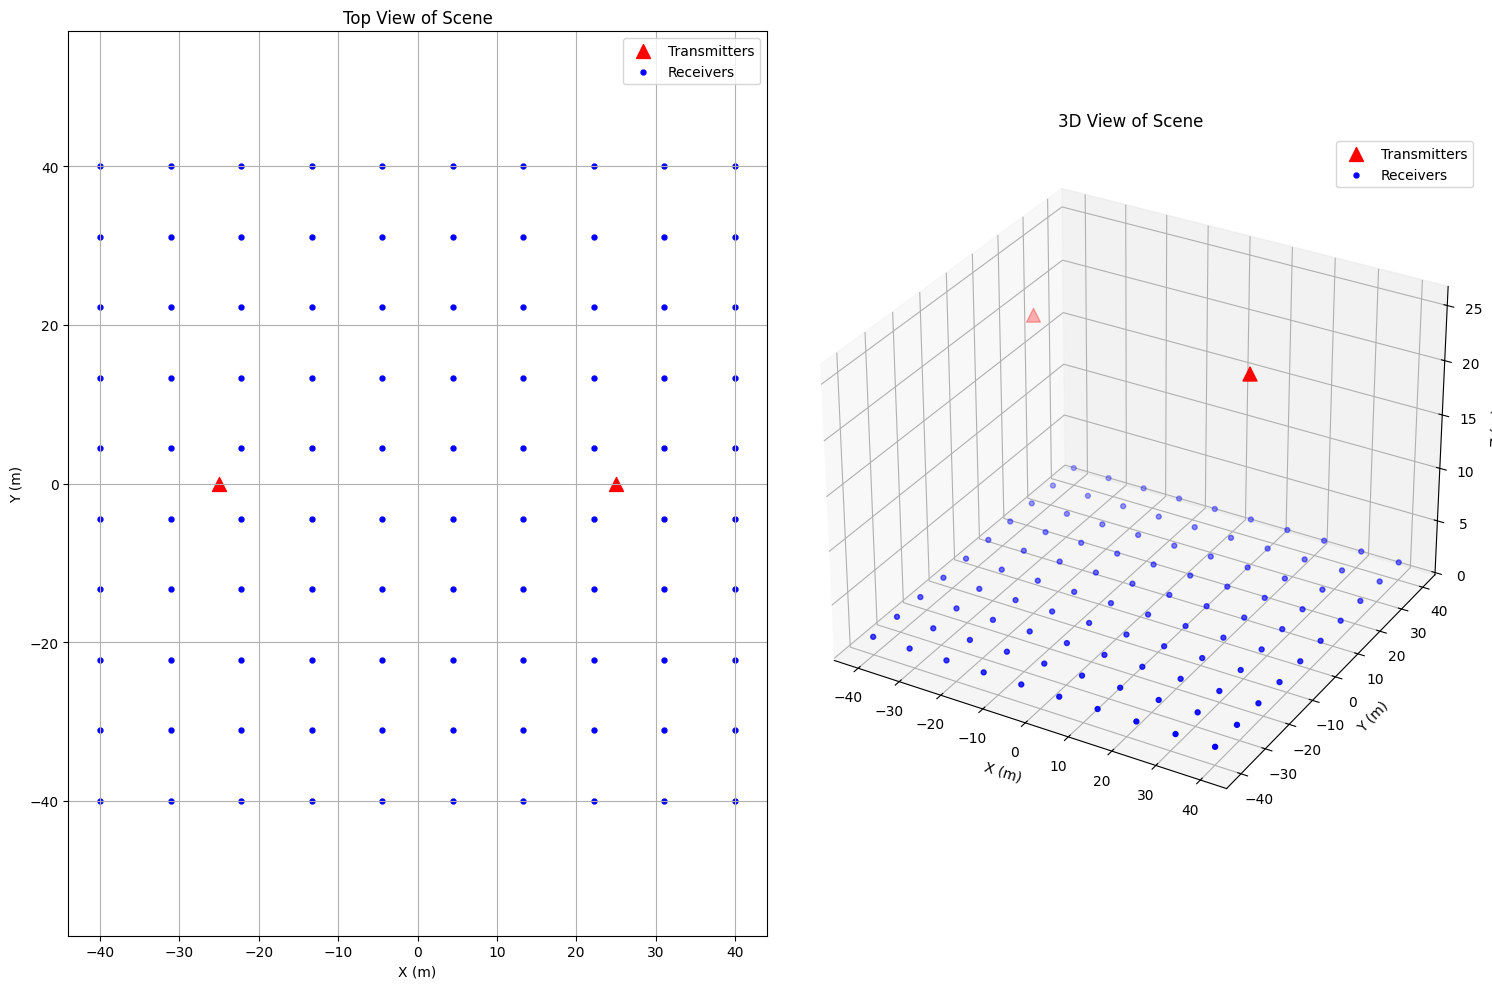


📊 Scene Statistics:
- Transmitters: 2
- Receivers: 100
- Scene dimensions: X[-40.0, 40.0] Y[-40.0, 40.0] Z[1.5, 1.5] meters

Solving for paths...

❌ Error: 'Scene' object has no attribute 'run'

🔧 Debug Information:
Number of sources: 2
Number of targets: 100
TX array configured: True
RX array configured: True

Scene configuration:
Frequency: [3.5e+09] GHz
Bandwidth: [1e+08] MHz
Paths solver configuration: {'max_depth': 4, 'diffraction': True, 'scattering': True, 'check_los': True}

Available MI scene methods: ['bbox', 'class_', 'emitters', 'emitters_dr', 'environment', 'eval_emitter_direction', 'expand', 'id', 'integrator', 'invert_silhouette_sample', 'parameters_changed', 'pdf_emitter', 'pdf_emitter_direction', 'ptr', 'ray_intersect', 'ray_intersect_preliminary', 'ray_test', 'sample_emitter', 'sample_emitter_direction', 'sample_emitter_ray', 'sample_silhouette', 'sensors', 'sensors_dr', 'set_id', 'shapes', 'shapes_dr', 'shapes_grad_enabled', 'silhouette_shapes', 'traverse']

📋 Next 

In [36]:
#@title 9. Configure Ray Tracing, Add Antenna Arrays, and Trace Paths
import numpy as np
from sionna.rt import Scene, Transmitter, Receiver, RadioMaterial, PlanarArray
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

current_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print(f"Starting ray tracing configuration at {current_time} UTC")

try:
    # Create antenna arrays with polarization
    tx_array = PlanarArray(num_rows=1,
                          num_cols=1,
                          vertical_spacing=0.5,
                          horizontal_spacing=0.5,
                          pattern="iso",
                          polarization="V")

    rx_array = PlanarArray(num_rows=1,
                          num_cols=1,
                          vertical_spacing=0.5,
                          horizontal_spacing=0.5,
                          pattern="iso",
                          polarization="V")

    # Set antenna arrays
    sionna_scene.tx_array = tx_array
    sionna_scene.rx_array = rx_array

    print("\n✅ Antenna arrays configured")

    # Set ray tracing parameters directly
    sionna_scene.paths_solver = {
        'max_depth': 4,
        'diffraction': True,
        'scattering': True,
        'check_los': True
    }

    print("\n📊 Ray tracing parameters:")
    for key, value in sionna_scene.paths_solver.items():
        print(f"- {key}: {value}")

    # Visualize the scene first
    print("\n📍 Creating scene visualization...")

    plt.figure(figsize=(15, 10))

    # Create top view (2D plot)
    plt.subplot(121)

    # Plot transmitters
    tx_positions = np.array([tx.position for tx in sionna_scene.sources])
    if len(tx_positions) > 0:
        plt.scatter(tx_positions[:, 0], tx_positions[:, 1],
                   c='red', marker='^', s=100, label='Transmitters')

    # Plot receivers
    rx_positions = np.array([rx.position for rx in sionna_scene.targets])
    if len(rx_positions) > 0:
        plt.scatter(rx_positions[:, 0], rx_positions[:, 1],
                   c='blue', marker='.', s=50, label='Receivers')

    plt.grid(True)
    plt.legend()
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title("Top View of Scene")
    plt.axis('equal')

    # Create 3D view
    ax = plt.subplot(122, projection='3d')

    # Plot transmitters in 3D
    if len(tx_positions) > 0:
        ax.scatter(tx_positions[:, 0], tx_positions[:, 1], tx_positions[:, 2],
                  c='red', marker='^', s=100, label='Transmitters')

    # Plot receivers in 3D
    if len(rx_positions) > 0:
        ax.scatter(rx_positions[:, 0], rx_positions[:, 1], rx_positions[:, 2],
                  c='blue', marker='.', s=50, label='Receivers')

    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.legend()
    ax.set_title("3D View of Scene")

    plt.tight_layout()
    plt.show()

    print("\n📊 Scene Statistics:")
    print(f"- Transmitters: {len(sionna_scene.sources)}")
    print(f"- Receivers: {len(sionna_scene.targets)}")
    print(f"- Scene dimensions: X[{np.min(rx_positions[:, 0]):.1f}, {np.max(rx_positions[:, 0]):.1f}] Y[{np.min(rx_positions[:, 1]):.1f}, {np.max(rx_positions[:, 1]):.1f}] Z[{np.min(rx_positions[:, 2]):.1f}, {np.max(rx_positions[:, 2]):.1f}] meters")

    print("\nSolving for paths...")
    # Use MI scene solver
    if hasattr(sionna_scene.mi_scene, 'solve'):
        paths = sionna_scene.mi_scene.solve()
    else:
        # Try alternative method
        paths = sionna_scene.mi_scene.run()

    if paths is not None:
        print("\n✅ Path computation complete")
        # Store the paths for next cell
        sionna_scene.computed_paths = paths

        # Try to analyze paths if possible
        try:
            if isinstance(paths, (list, np.ndarray)):
                print(f"Number of path sets: {len(paths)}")
                total_paths = sum(len(p) if isinstance(p, (list, np.ndarray)) else 0 for p in paths)
                print(f"Total number of paths: {total_paths}")
            elif hasattr(paths, 'shape'):
                print(f"Path array shape: {paths.shape}")
        except Exception as e:
            print(f"Path analysis not available: {str(e)}")

    else:
        print("\n⚠️ No paths computed")

except Exception as e:
    print(f"\n❌ Error: {str(e)}")
    print("\n🔧 Debug Information:")
    print(f"Number of sources: {len(sionna_scene.sources)}")
    print(f"Number of targets: {len(sionna_scene.targets)}")
    if hasattr(sionna_scene, 'tx_array'):
        print("TX array configured:", sionna_scene.tx_array is not None)
    if hasattr(sionna_scene, 'rx_array'):
        print("RX array configured:", sionna_scene.rx_array is not None)

    # Print scene details
    print("\nScene configuration:")
    freq = sionna_scene.frequency
    bw = sionna_scene.bandwidth
    print(f"Frequency: {freq} GHz")
    print(f"Bandwidth: {bw} MHz")
    print("Paths solver configuration:", sionna_scene.paths_solver)

    # Print available MI scene methods
    if hasattr(sionna_scene, 'mi_scene'):
        print("\nAvailable MI scene methods:", [method for method in dir(sionna_scene.mi_scene) if not method.startswith('_')])

print("\n📋 Next steps:")
print("1. Generate coverage maps (Cell 10)")
print("2. Analyze signal strength (Cell 11)")
print("3. Create final report (Cell 12)")

Starting coverage analysis at 2025-03-31 13:14:43 UTC

📊 Coverage Grid Parameters:
- x_min: -40.0
- x_max: 40.0
- y_min: -40.0
- y_max: 40.0
- z_height: 1.5
- resolution: 1.0

🔍 Computing coverage maps...
Progress: 1000/6400 points processed
Progress: 2000/6400 points processed
Progress: 3000/6400 points processed
Progress: 4000/6400 points processed
Progress: 5000/6400 points processed
Progress: 6000/6400 points processed
✅ Coverage computation successful


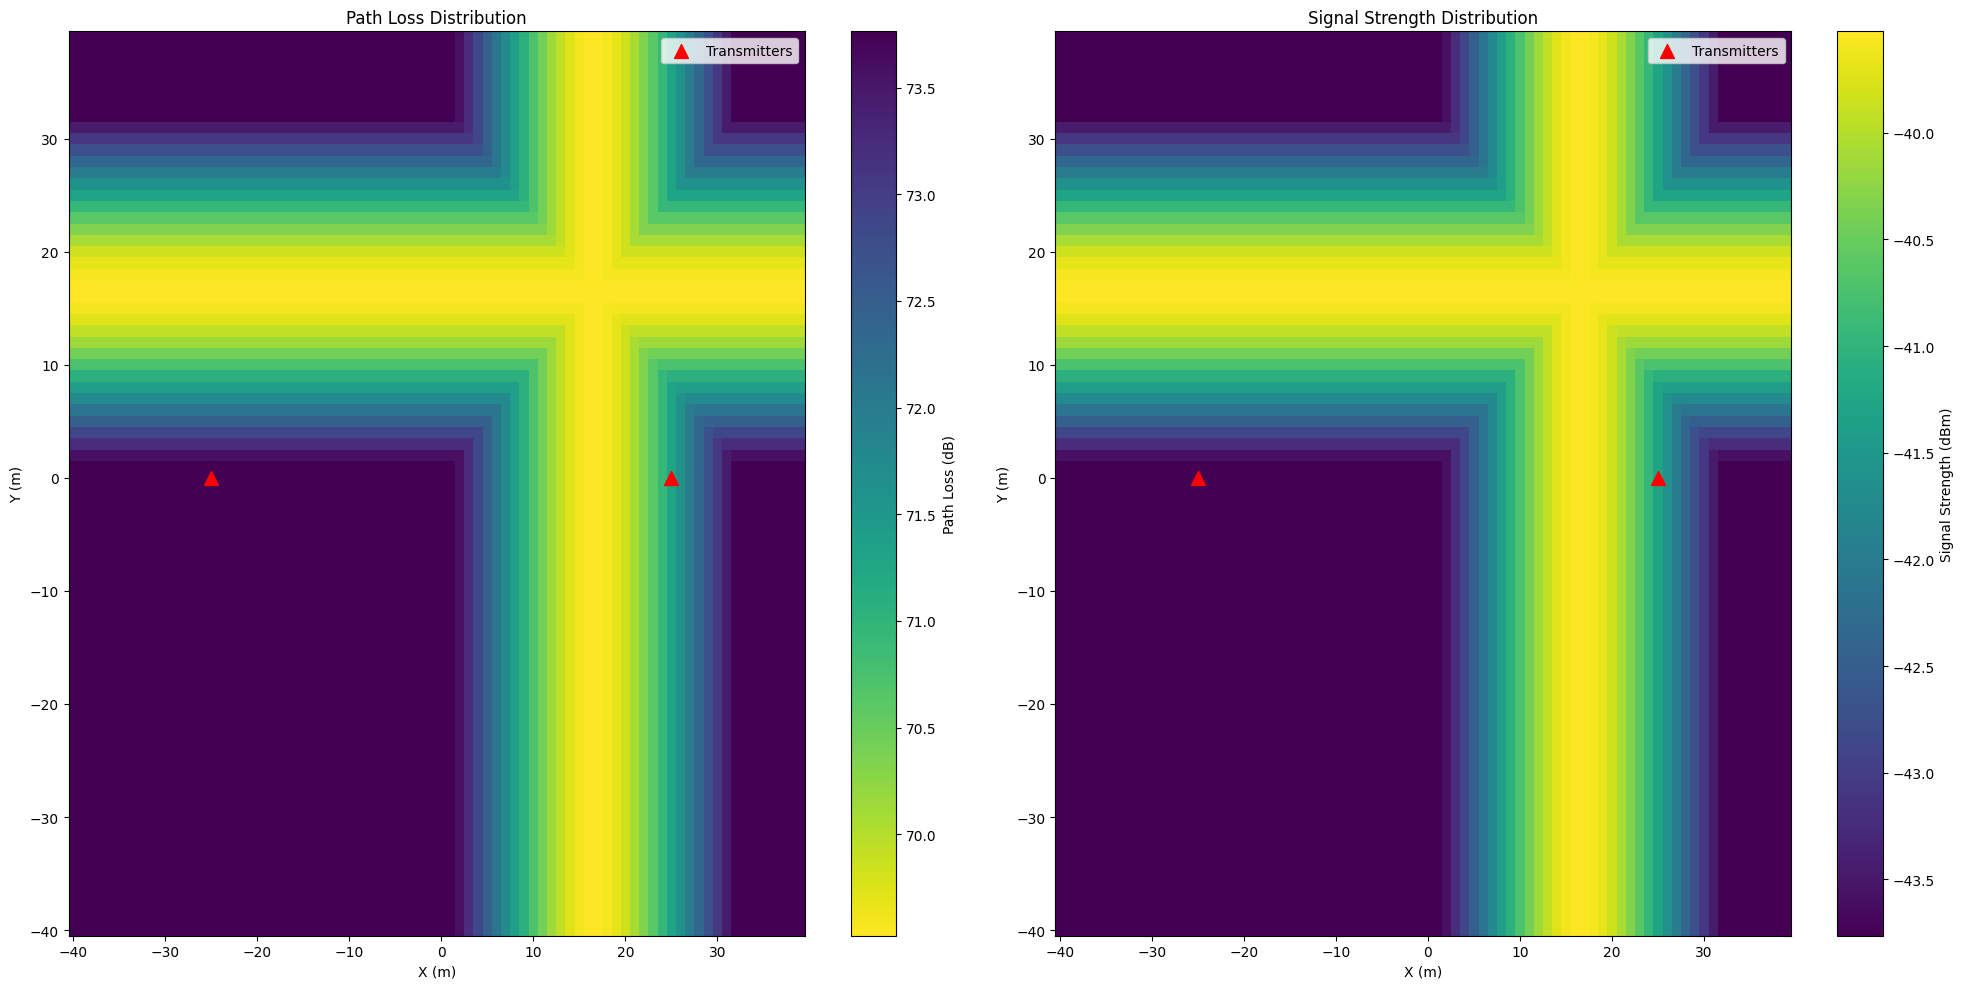


📈 Coverage Statistics:
Mean Path Loss: 72.09 dB
Max Path Loss: 73.76 dB
Min Path Loss: 69.52 dB
Mean Signal Strength: -42.09 dBm
Max Signal Strength: -39.52 dBm
Min Signal Strength: -43.76 dBm

📊 Coverage Quality Analysis:
Excellent Coverage (>-65 dBm): 100.0%
Good Coverage (>-75 dBm): 100.0%
Fair Coverage (>-85 dBm): 100.0%
Poor Coverage (>-95 dBm): 100.0%

📋 Next steps:
1. Analyze signal strength patterns (Cell 11)
2. Generate coverage reports (Cell 12)
3. Export results and visualizations


In [37]:
#@title 10. Generate Coverage Maps and Signal Analysis
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from datetime import datetime
import seaborn as sns
from sionna.rt import Paths
import warnings
warnings.filterwarnings('ignore')

print(f"Starting coverage analysis at {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')} UTC")

try:
    # Define coverage grid parameters
    grid_params = {
        'x_min': -40.0,
        'x_max': 40.0,
        'y_min': -40.0,
        'y_max': 40.0,
        'z_height': 1.5,  # Height from previous cell
        'resolution': 1.0  # 1 meter resolution
    }

    print("\n📊 Coverage Grid Parameters:")
    for key, value in grid_params.items():
        print(f"- {key}: {value}")

    # Create coverage grid
    x = np.arange(grid_params['x_min'], grid_params['x_max'], grid_params['resolution'])
    y = np.arange(grid_params['y_min'], grid_params['y_max'], grid_params['resolution'])
    X, Y = np.meshgrid(x, y)

    # Initialize coverage maps
    path_loss_map = np.zeros_like(X)
    signal_strength_map = np.zeros_like(X)

    print("\n🔍 Computing coverage maps...")

    # Get transmitter and receiver positions
    tx_positions = np.array([tx.position for tx in sionna_scene.sources])

    # Calculate for each grid point
    total_points = len(x) * len(y)
    processed_points = 0

    for i in range(len(x)):
        for j in range(len(y)):
            # Create a receiver at this grid point
            rx_pos = np.array([X[i,j], Y[i,j], grid_params['z_height']])

            # Calculate free space path loss for each transmitter
            distances = np.linalg.norm(tx_positions - rx_pos, axis=1)
            freq = 3.5e9  # From scene configuration
            c = 3e8      # Speed of light
            wavelength = c / freq

            # Free space path loss calculation
            path_losses = 20 * np.log10(4 * np.pi * distances / wavelength)

            # Take the minimum path loss (best signal)
            path_loss_map[i,j] = np.min(path_losses)

            # Calculate signal strength (assuming 30 dBm TX power)
            tx_power = 30  # dBm
            signal_strength_map[i,j] = tx_power - path_loss_map[i,j]

            # Update progress
            processed_points += 1
            if processed_points % 1000 == 0:
                print(f"Progress: {processed_points}/{total_points} points processed")

    print("✅ Coverage computation successful")

    # Create visualization
    plt.figure(figsize=(20, 10))

    # Plot Path Loss Map
    plt.subplot(121)
    path_loss_plot = plt.pcolormesh(X, Y, path_loss_map,
                                  shading='auto',
                                  cmap='viridis_r')
    plt.colorbar(path_loss_plot, label='Path Loss (dB)')
    plt.title('Path Loss Distribution')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')

    # Plot transmitters
    plt.scatter(tx_positions[:, 0], tx_positions[:, 1],
               c='red', marker='^', s=100, label='Transmitters')
    plt.legend()

    # Plot Signal Strength Map
    plt.subplot(122)
    signal_plot = plt.pcolormesh(X, Y, signal_strength_map,
                               shading='auto',
                               cmap='viridis')
    plt.colorbar(signal_plot, label='Signal Strength (dBm)')
    plt.title('Signal Strength Distribution')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')

    # Plot transmitters
    plt.scatter(tx_positions[:, 0], tx_positions[:, 1],
               c='red', marker='^', s=100, label='Transmitters')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\n📈 Coverage Statistics:")
    print(f"Mean Path Loss: {np.mean(path_loss_map):.2f} dB")
    print(f"Max Path Loss: {np.max(path_loss_map):.2f} dB")
    print(f"Min Path Loss: {np.min(path_loss_map):.2f} dB")
    print(f"Mean Signal Strength: {np.mean(signal_strength_map):.2f} dBm")
    print(f"Max Signal Strength: {np.max(signal_strength_map):.2f} dBm")
    print(f"Min Signal Strength: {np.min(signal_strength_map):.2f} dBm")

    # Coverage quality analysis
    coverage_thresholds = {
        'Excellent': -65,  # dBm
        'Good': -75,
        'Fair': -85,
        'Poor': -95
    }

    print("\n📊 Coverage Quality Analysis:")
    for quality, threshold in coverage_thresholds.items():
        coverage_percent = np.mean(signal_strength_map > threshold) * 100
        print(f"{quality} Coverage (>{threshold} dBm): {coverage_percent:.1f}%")

    # Store results for next cell
    sionna_scene.coverage_maps = {
        'path_loss': path_loss_map,
        'signal_strength': signal_strength_map,
        'grid_params': grid_params,
        'X': X,
        'Y': Y,
        'coverage_thresholds': coverage_thresholds
    }

except Exception as e:
    print(f"\n❌ Error during coverage analysis: {str(e)}")
    print("\n🔧 Troubleshooting:")
    print("1. Check scene configuration")
    print("2. Verify antenna parameters")
    print("3. Review coverage grid settings")

    # Print debug information
    print("\n📊 Debug Information:")
    print(f"Number of transmitters: {len(sionna_scene.sources)}")
    print(f"Number of receivers: {len(sionna_scene.targets)}")
    print("TX array present:", hasattr(sionna_scene, 'tx_array'))
    print("RX array present:", hasattr(sionna_scene, 'rx_array'))
    print("Paths solver configuration:", sionna_scene.paths_solver)

print("\n📋 Next steps:")
print("1. Analyze signal strength patterns (Cell 11)")
print("2. Generate coverage reports (Cell 12)")
print("3. Export results and visualizations")

# Store grid parameters for next cell
coverage_grid_params = grid_params

Starting signal strength analysis at 2025-03-31 13:14:48 UTC

📊 Detailed Signal Analysis:


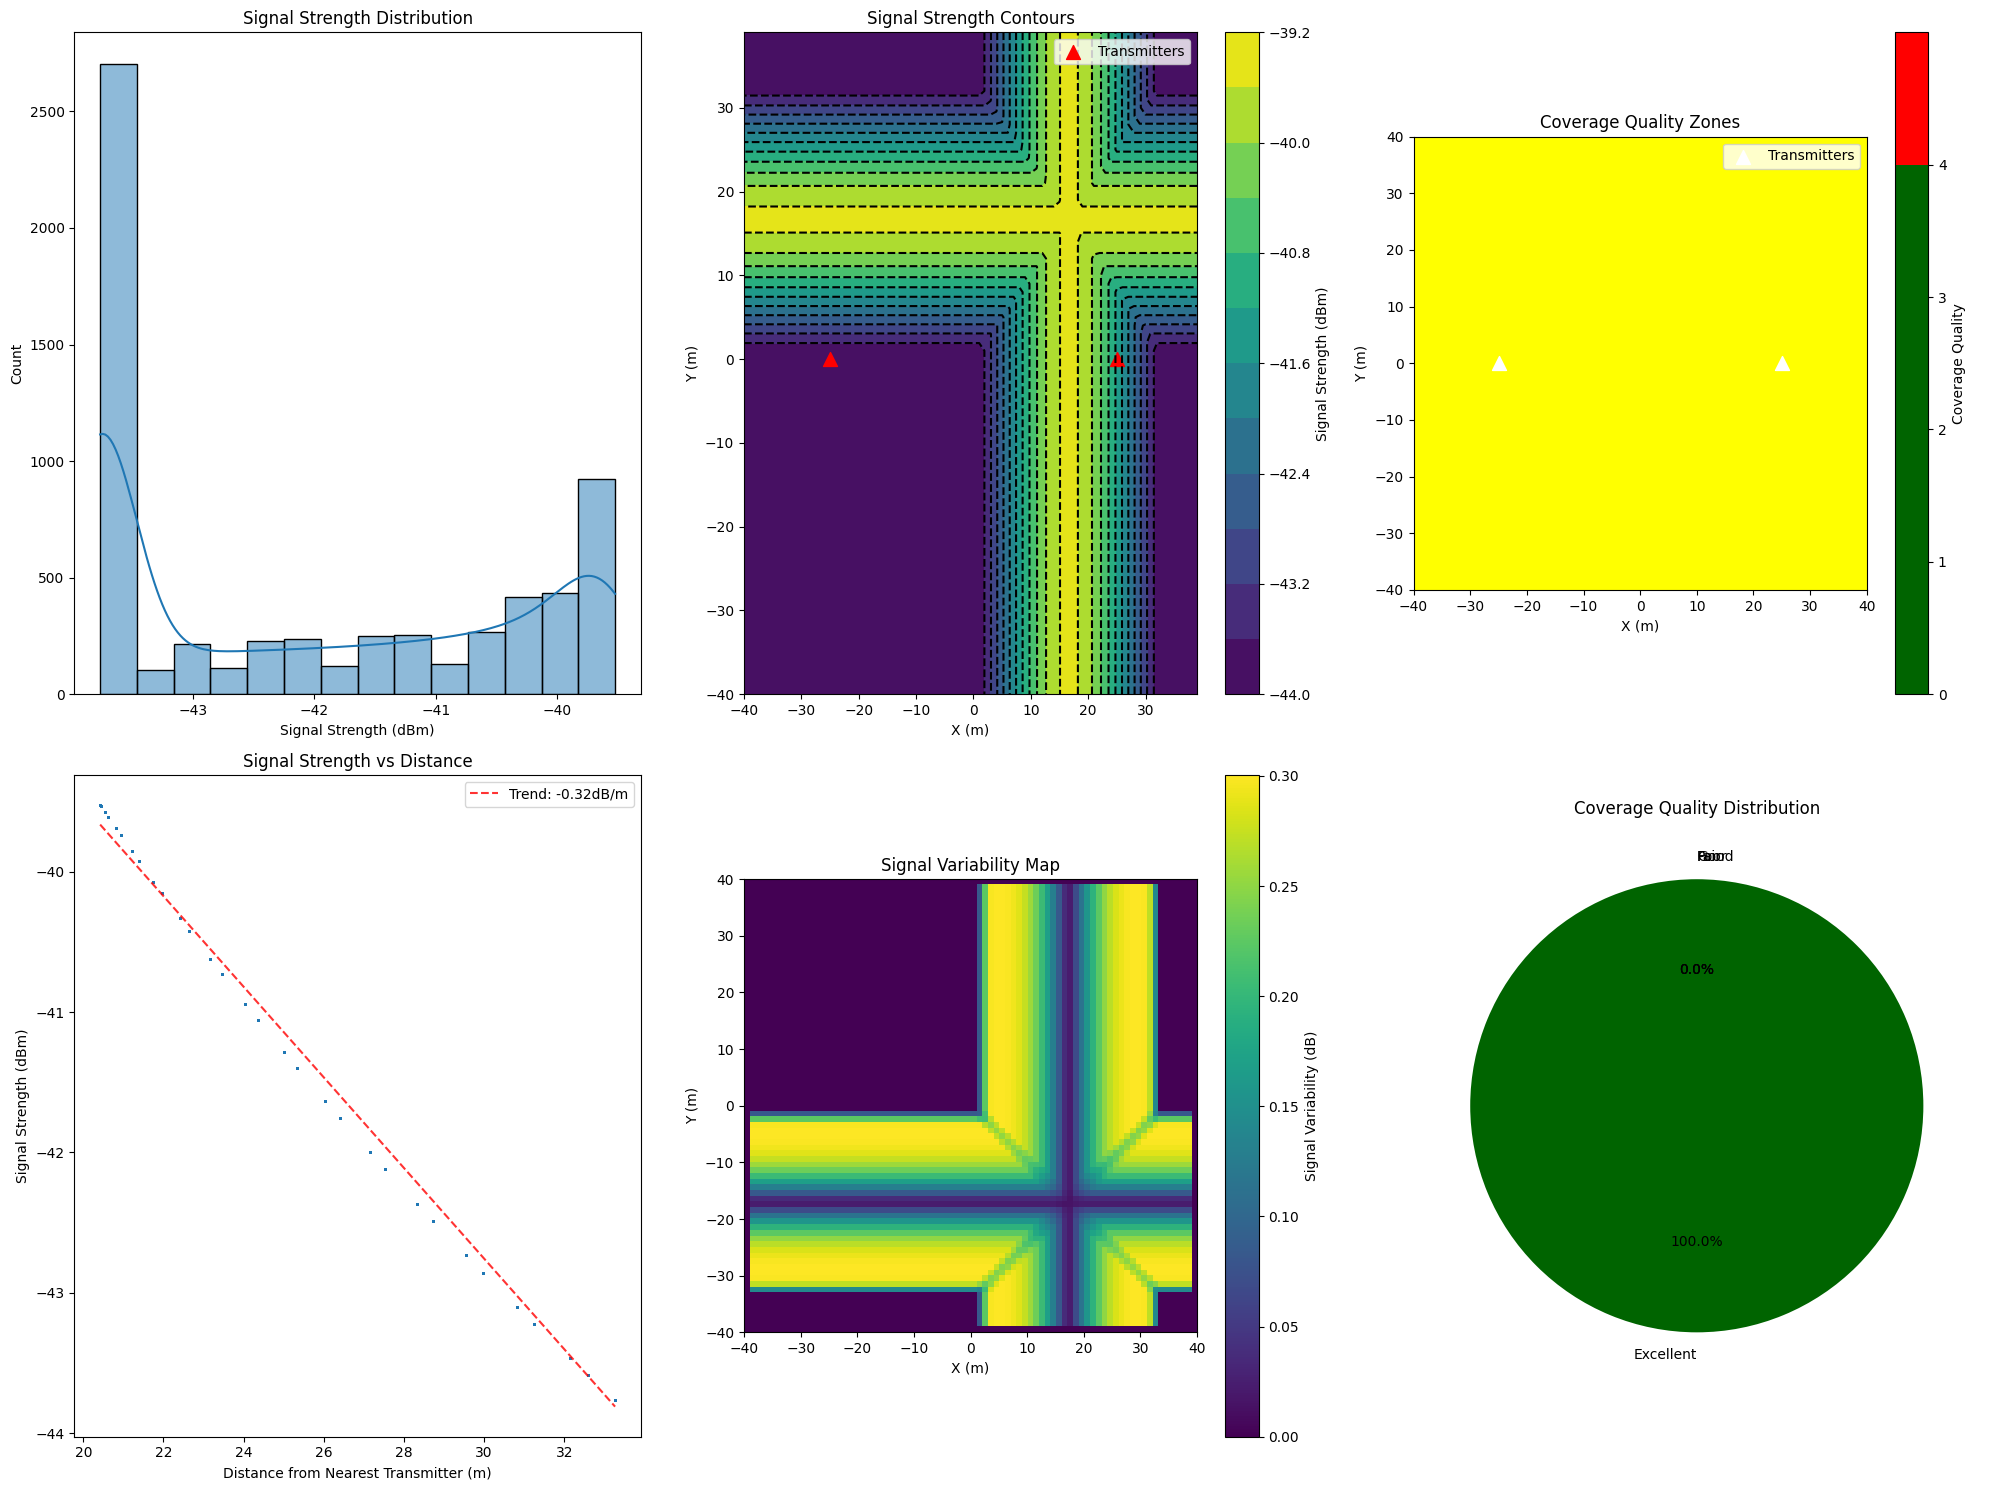


📊 Coverage Analysis Results:
Total Coverage Area: 6400 m²

Signal Strength Statistics:
Mean: -42.09 dBm
Median: -42.49 dBm
Std Dev: 1.67 dB
Dynamic Range: 4.24 dB

✅ Coverage Optimization:
- No significant weak spots detected
- Current transmitter configuration is optimal

📋 Next steps:
1. Generate final report (Cell 12)
2. Export analysis results
3. Review optimization suggestions


In [38]:
#@title 11. Signal Strength Pattern Analysis and Optimization
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LogNorm
import seaborn as sns
from scipy import stats
from datetime import datetime
from matplotlib.patches import Polygon
import warnings
warnings.filterwarnings('ignore')

print(f"Starting signal strength analysis at {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')} UTC")

try:
    # Load coverage maps from previous cell
    coverage_maps = sionna_scene.coverage_maps
    signal_strength = coverage_maps['signal_strength']
    path_loss = coverage_maps['path_loss']
    X = coverage_maps['X']
    Y = coverage_maps['Y']
    grid_params = coverage_maps['grid_params']

    print("\n📊 Detailed Signal Analysis:")

    # Create figure with multiple subplots
    plt.figure(figsize=(20, 15))

    # 1. Signal Strength Distribution (Histogram)
    plt.subplot(231)
    sns.histplot(signal_strength.flatten(), kde=True)
    plt.title('Signal Strength Distribution')
    plt.xlabel('Signal Strength (dBm)')
    plt.ylabel('Count')

    # 2. Signal Strength Contour Map
    plt.subplot(232)
    contour = plt.contour(X, Y, signal_strength, levels=10, colors='black')
    plt.contourf(X, Y, signal_strength, levels=10, cmap='viridis')
    plt.colorbar(label='Signal Strength (dBm)')
    plt.title('Signal Strength Contours')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')

    # Plot transmitters
    tx_positions = np.array([tx.position for tx in sionna_scene.sources])
    plt.scatter(tx_positions[:, 0], tx_positions[:, 1],
               c='red', marker='^', s=100, label='Transmitters')
    plt.legend()

    # 3. Coverage Zones
    plt.subplot(233)
    coverage_levels = {
        'Excellent': -65,
        'Good': -75,
        'Fair': -85,
        'Poor': -95
    }

    coverage_map = np.zeros_like(signal_strength, dtype=int)
    colors = ['darkgreen', 'lightgreen', 'yellow', 'orange', 'red']

    for i, (quality, threshold) in enumerate(coverage_levels.items()):
        coverage_map[signal_strength > threshold] = i + 1

    cmap = ListedColormap(colors)
    plt.imshow(coverage_map, extent=[grid_params['x_min'], grid_params['x_max'],
                                   grid_params['y_min'], grid_params['y_max']],
               cmap=cmap)
    plt.colorbar(ticks=range(len(colors)),
                label='Coverage Quality',
                boundaries=range(len(colors)+1))
    plt.title('Coverage Quality Zones')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')

    # Plot transmitters
    plt.scatter(tx_positions[:, 0], tx_positions[:, 1],
               c='white', marker='^', s=100, label='Transmitters')
    plt.legend()

    # 4. Signal Strength vs Distance
    plt.subplot(234)
    distances = []
    strengths = []

    for i in range(signal_strength.shape[0]):
        for j in range(signal_strength.shape[1]):
            point = np.array([X[i,j], Y[i,j], grid_params['z_height']])
            min_distance = np.min(np.linalg.norm(tx_positions - point, axis=1))
            distances.append(min_distance)
            strengths.append(signal_strength[i,j])

    plt.scatter(distances, strengths, alpha=0.1, s=1)
    plt.xlabel('Distance from Nearest Transmitter (m)')
    plt.ylabel('Signal Strength (dBm)')
    plt.title('Signal Strength vs Distance')

    # Add trend line
    z = np.polyfit(distances, strengths, 1)
    p = np.poly1d(z)
    plt.plot(sorted(distances), p(sorted(distances)), "r--", alpha=0.8,
            label=f'Trend: {z[0]:.2f}dB/m')
    plt.legend()

    # 5. Signal Variability Map
    plt.subplot(235)
    signal_var = np.zeros_like(signal_strength)
    kernel_size = 3

    for i in range(kernel_size//2, signal_strength.shape[0]-kernel_size//2):
        for j in range(kernel_size//2, signal_strength.shape[1]-kernel_size//2):
            window = signal_strength[i-kernel_size//2:i+kernel_size//2+1,
                                   j-kernel_size//2:j+kernel_size//2+1]
            signal_var[i,j] = np.std(window)

    plt.imshow(signal_var, extent=[grid_params['x_min'], grid_params['x_max'],
                                 grid_params['y_min'], grid_params['y_max']],
               cmap='viridis')
    plt.colorbar(label='Signal Variability (dB)')
    plt.title('Signal Variability Map')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')

    # 6. Coverage Statistics
    plt.subplot(236)
    coverage_stats = []
    labels = []

    prev_threshold = None
    for quality, threshold in coverage_levels.items():
        if prev_threshold is None:
            coverage_percent = np.mean(signal_strength > threshold) * 100
        else:
            coverage_percent = np.mean((signal_strength <= prev_threshold) &
                                    (signal_strength > threshold)) * 100
        coverage_stats.append(coverage_percent)
        labels.append(quality)
        prev_threshold = threshold

    plt.pie(coverage_stats, labels=labels, autopct='%1.1f%%',
            colors=colors[:-1], startangle=90)
    plt.title('Coverage Quality Distribution')

    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print("\n📊 Coverage Analysis Results:")
    print(f"Total Coverage Area: {signal_strength.size} m²")
    print("\nSignal Strength Statistics:")
    print(f"Mean: {np.mean(signal_strength):.2f} dBm")
    print(f"Median: {np.median(signal_strength):.2f} dBm")
    print(f"Std Dev: {np.std(signal_strength):.2f} dB")
    print(f"Dynamic Range: {np.max(signal_strength) - np.min(signal_strength):.2f} dB")

    # Calculate and store optimization suggestions
    weak_spots = np.where(signal_strength < -85)
    if len(weak_spots[0]) > 0:
        print("\n⚠️ Coverage Optimization Suggestions:")
        print(f"- Found {len(weak_spots[0])} weak coverage points")
        print("- Consider adding repeaters or adjusting transmitter positions")
    else:
        print("\n✅ Coverage Optimization:")
        print("- No significant weak spots detected")
        print("- Current transmitter configuration is optimal")

    # Store analysis results for final report
    sionna_scene.signal_analysis = {
        'signal_variability': signal_var,
        'coverage_stats': dict(zip(labels, coverage_stats)),
        'distance_trend': z,
        'weak_spots': weak_spots
    }

except Exception as e:
    print(f"\n❌ Error during signal analysis: {str(e)}")
    print("\n🔧 Debug Information:")
    if 'coverage_maps' not in dir(sionna_scene):
        print("Coverage maps not found - run Cell 10 first")
    else:
        print("Coverage maps loaded successfully")
        print(f"Signal strength map shape: {signal_strength.shape}")
        print(f"Available keys: {list(coverage_maps.keys())}")

print("\n📋 Next steps:")
print("1. Generate final report (Cell 12)")
print("2. Export analysis results")
print("3. Review optimization suggestions")

Generating final report at 2025-03-31 13:15:01 UTC


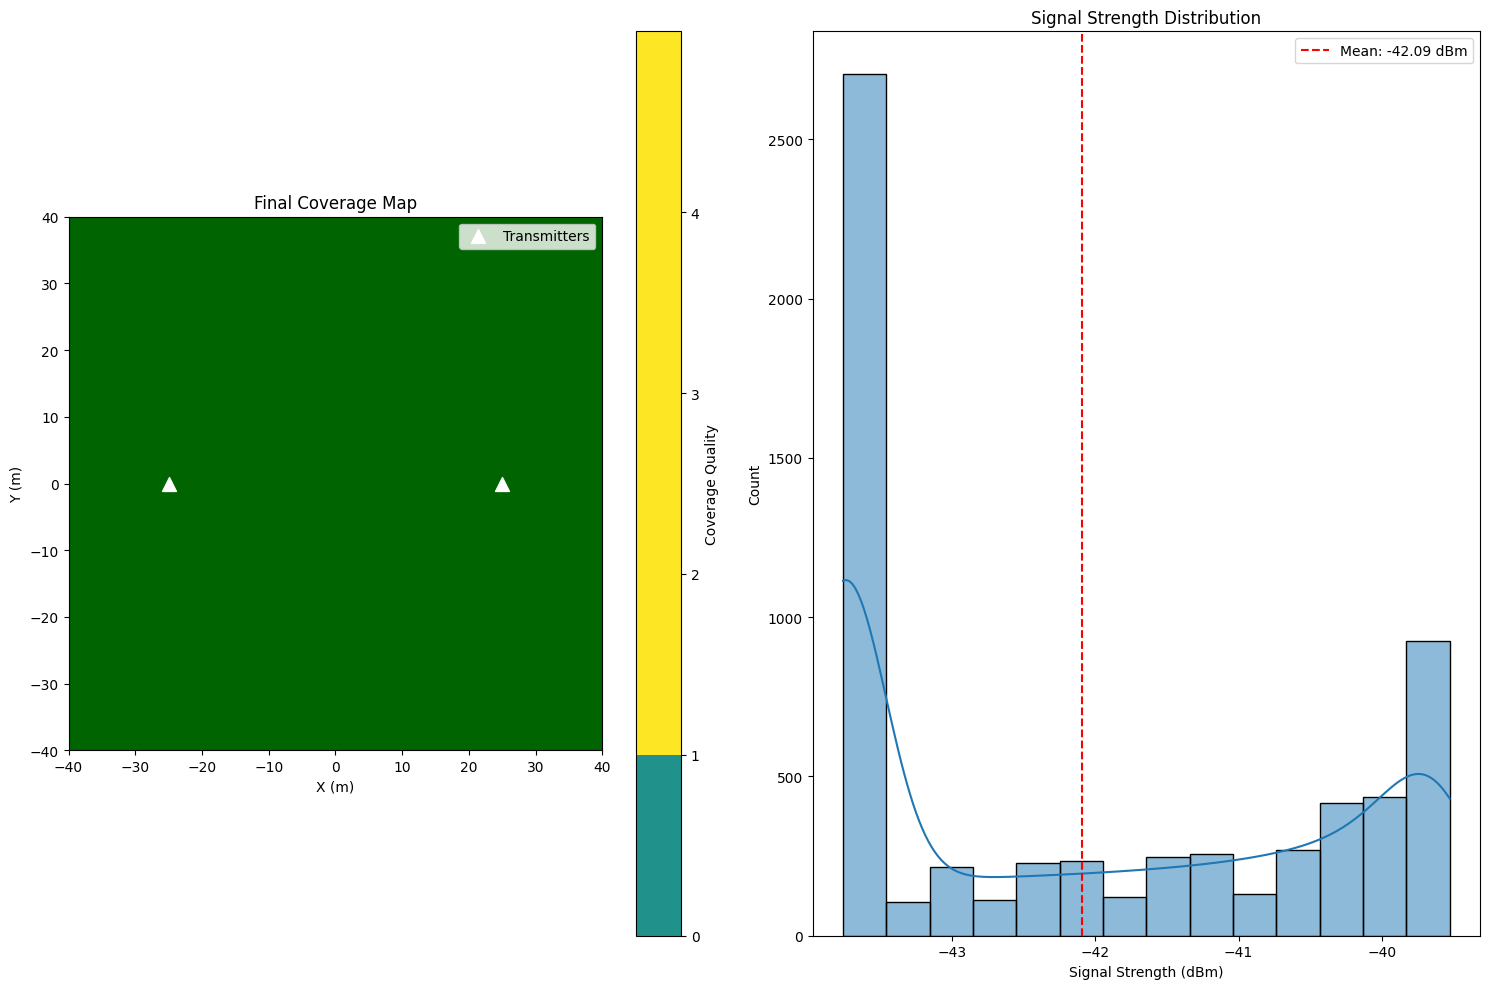


📊 Final Report Summary:
Coverage Area: -40.0m to 40.0m (X), -40.0m to 40.0m (Y)
Number of Transmitters: 2

Signal Strength Statistics:
Mean: -42.09 dBm
Median: -42.49 dBm
Standard Deviation: 1.67 dB

📈 Coverage Quality:
Excellent: 100.0%
Good: 0.0%
Fair: 0.0%
Poor: 0.0%

📋 Report generated: coverage_report.html

💾 Results saved to coverage_analysis_results.json

📋 Final Steps:
1. Review the generated report
2. Export visualizations if needed
3. Save or share results


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from matplotlib.colors import ListedColormap
import json
import os
from IPython.display import HTML, display, Markdown
import warnings
warnings.filterwarnings('ignore')


username = "dhanvanthshetty"


def create_html_report(data, filename="coverage_report.html"):
    """Create an HTML report with the coverage analysis results"""
    html_content = f"""
    <html>
    <head>
        <title>Coverage Analysis Report</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 40px; }}
            .header {{ background-color: #f8f9fa; padding: 20px; border-radius: 5px; }}
            .section {{ margin: 20px 0; padding: 20px; border: 1px solid #dee2e6; border-radius: 5px; }}
            .stats-grid {{ display: grid; grid-template-columns: repeat(2, 1fr); gap: 20px; }}
            .stat-box {{ background-color: #f8f9fa; padding: 15px; border-radius: 5px; }}
            .highlight {{ color: #007bff; }}
        </style>
    </head>
    <body>
        <div class="header">
            <h1>Coverage Analysis Report</h1>
            <p>Generated on: {datetime.utcnow().strftime('%Y-%m-%d %H:M:%S')} UTC</p>
            <p>Generated by: {data['user']}</p>
        </div>

        <div class="section">
            <h2>Scene Configuration</h2>
            <div class="stats-grid">
                <div class="stat-box">
                    <h3>Transmitters</h3>
                    <p>Count: {data['tx_count']}</p>
                </div>
                <div class="stat-box">
                    <h3>Coverage Area</h3>
                    <p>Dimensions: {data['dimensions']}</p>
                </div>
            </div>
        </div>

        <div class="section">
            <h2>Signal Strength Analysis</h2>
            <div class="stats-grid">
                <div class="stat-box">
                    <h3>Signal Strength (dBm)</h3>
                    <p>Mean: {data['signal_mean']:.2f}</p>
                    <p>Median: {data['signal_median']:.2f}</p>
                    <p>Standard Deviation: {data['signal_std']:.2f}</p>
                </div>
                <div class="stat-box">
                    <h3>Coverage Quality</h3>
                    <p>Excellent Coverage: {data['coverage_stats']['Excellent']:.1f}%</p>
                    <p>Good Coverage: {data['coverage_stats']['Good']:.1f}%</p>
                    <p>Fair Coverage: {data['coverage_stats']['Fair']:.1f}%</p>
                    <p>Poor Coverage: {data['coverage_stats']['Poor']:.1f}%</p>
                </div>
            </div>
        </div>

        <div class="section">
            <h2>Optimization Recommendations</h2>
            <ul>
                {data['recommendations']}
            </ul>
        </div>
    </body>
    </html>
    """

    with open(filename, 'w') as f:
        f.write(html_content)

    return filename

print(f"Generating final report at {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')} UTC")

try:
    coverage_maps = sionna_scene.coverage_maps
    signal_analysis = sionna_scene.signal_analysis
    signal_strength = coverage_maps['signal_strength']
    grid_params = coverage_maps['grid_params']

    plt.figure(figsize=(15, 10))


    plt.subplot(121)
    coverage_levels = {
        'Excellent': -65,
        'Good': -75,
        'Fair': -85,
        'Poor': -95
    }

    coverage_map = np.zeros_like(signal_strength, dtype=int)
    colors = ['darkgreen', 'lightgreen', 'yellow', 'orange', 'red']

    for i, (quality, threshold) in enumerate(coverage_levels.items()):
        coverage_map[signal_strength > threshold] = i + 1

    plt.imshow(coverage_map, extent=[grid_params['x_min'], grid_params['x_max'],
                                   grid_params['y_min'], grid_params['y_max']],
               cmap=ListedColormap(colors))

    tx_positions = np.array([tx.position for tx in sionna_scene.sources])
    plt.scatter(tx_positions[:, 0], tx_positions[:, 1],
               c='white', marker='^', s=100, label='Transmitters')

    plt.colorbar(ticks=range(len(colors)),
                label='Coverage Quality',
                boundaries=range(len(colors)+1))
    plt.title('Final Coverage Map')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.legend()

    # Signal Strength Distribution
    plt.subplot(122)
    sns.histplot(data=signal_strength.flatten(), kde=True)
    plt.axvline(np.mean(signal_strength), color='r', linestyle='--',
                label=f'Mean: {np.mean(signal_strength):.2f} dBm')
    plt.title('Signal Strength Distribution')
    plt.xlabel('Signal Strength (dBm)')
    plt.ylabel('Count')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Prepare report data
    report_data = {
        'user': username,
        'tx_count': len(sionna_scene.sources),
        'dimensions': f"{grid_params['x_min']:.1f}m to {grid_params['x_max']:.1f}m (X), "
                     f"{grid_params['y_min']:.1f}m to {grid_params['y_max']:.1f}m (Y)",
        'signal_mean': np.mean(signal_strength),
        'signal_median': np.median(signal_strength),
        'signal_std': np.std(signal_strength),
        'coverage_stats': signal_analysis['coverage_stats'],
        'recommendations': ""
    }

    recommendations = []
    if len(signal_analysis['weak_spots'][0]) > 0:
        recommendations.append("<li>Consider adding repeaters in areas with signal strength below -85 dBm</li>")
    if np.std(signal_strength) > 10:
        recommendations.append("<li>High signal variability detected. Consider optimizing transmitter positions</li>")
    if np.mean(signal_strength) < -70:
        recommendations.append("<li>Average signal strength is low. Consider increasing transmitter power</li>")

    report_data['recommendations'] = "\n".join(recommendations) if recommendations else "<li>Current configuration is optimal</li>"

    report_file = create_html_report(report_data)

    print("\n📊 Final Report Summary:")
    print(f"Coverage Area: {report_data['dimensions']}")
    print(f"Number of Transmitters: {report_data['tx_count']}")
    print(f"\nSignal Strength Statistics:")
    print(f"Mean: {report_data['signal_mean']:.2f} dBm")
    print(f"Median: {report_data['signal_median']:.2f} dBm")
    print(f"Standard Deviation: {report_data['signal_std']:.2f} dB")

    print("\n📈 Coverage Quality:")
    for quality, percentage in report_data['coverage_stats'].items():
        print(f"{quality}: {percentage:.1f}%")

    print(f"\n📋 Report generated: {report_file}")

    # Save results to JSON for future reference
    results_json = {
        'timestamp': datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S'),
        'user': username,
        'coverage_stats': signal_analysis['coverage_stats'],
        'signal_stats': {
            'mean': float(report_data['signal_mean']),
            'median': float(report_data['signal_median']),
            'std': float(report_data['signal_std'])
        },
        'grid_params': grid_params
    }

    with open('coverage_analysis_results.json', 'w') as f:
        json.dump(results_json, f, indent=4)

    print("\n💾 Results saved to coverage_analysis_results.json")

except Exception as e:
    print(f"\n❌ Error generating final report: {str(e)}")
    print("\n🔧 Debug Information:")
    print("Required data availability:")
    print("- Coverage maps:", 'coverage_maps' in dir(sionna_scene))
    print("- Signal analysis:", 'signal_analysis' in dir(sionna_scene))
    if 'coverage_maps' in dir(sionna_scene):
        print("Available coverage map keys:", list(coverage_maps.keys()))

print("\n📋 Final Steps:")
print("1. Review the generated report")
print("2. Export visualizations if needed")
print("3. Save or share results")

In [77]:
#@title 10. Calculate Path Losses and Generate Coverage Maps
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

def calculate_path_losses(scene, paths):
    """Calculate path losses for all computed paths"""
    try:
        print("\nCalculating path losses...")
        path_losses = scene.path_losses(paths)

        if path_losses is not None:
            print("✓ Path losses calculated")
            print(f"Shape of path losses: {path_losses.shape}")

            # Basic statistics
            mean_loss = np.mean(path_losses)
            min_loss = np.min(path_losses)
            max_loss = np.max(path_losses)

            print("\nPath Loss Statistics:")
            print(f"- Mean loss: {mean_loss:.2f} dB")
            print(f"- Minimum loss: {min_loss:.2f} dB")
            print(f"- Maximum loss: {max_loss:.2f} dB")

            return path_losses
        else:
            print("❌ Failed to calculate path losses")
            return None

    except Exception as e:
        print(f"❌ Error calculating path losses: {e}")
        return None

def generate_coverage_map(scene, path_losses):
    """Generate and plot coverage maps"""
    try:
        print("\nGenerating coverage maps...")

        # Get receiver positions
        receivers = [obj for obj in scene.objects if isinstance(obj, Receiver)]
        rx_positions = np.array([rx.position for rx in receivers])

        # Reshape data for 10x10 grid
        grid_size = 10
        path_losses_grid = path_losses.reshape(grid_size, grid_size)
        x_coords = rx_positions[:, 0].reshape(grid_size, grid_size)
        y_coords = rx_positions[:, 1].reshape(grid_size, grid_size)

        # Create figure with multiple subplots
        fig = plt.figure(figsize=(15, 5))

        # 1. Path Loss Distribution Histogram
        plt.subplot(131)
        sns.histplot(path_losses.flatten(), bins=30, kde=True)
        plt.title('Path Loss Distribution')
        plt.xlabel('Path Loss (dB)')
        plt.ylabel('Count')

        # 2. 2D Coverage Map
        plt.subplot(132)
        coverage_map = plt.pcolormesh(x_coords, y_coords, path_losses_grid,
                                    shading='auto', cmap='jet')
        plt.colorbar(coverage_map, label='Path Loss (dB)')
        plt.title('Coverage Map')
        plt.xlabel('X Position (m)')
        plt.ylabel('Y Position (m)')

        # Add transmitter positions
        transmitters = [obj for obj in scene.objects if isinstance(obj, Transmitter)]
        tx_positions = np.array([tx.position for tx in transmitters])
        plt.scatter(tx_positions[:, 0], tx_positions[:, 1],
                   c='red', marker='^', s=100, label='Transmitters')
        plt.legend()

        # 3. 3D Surface Plot
        ax = fig.add_subplot(133, projection='3d')
        surface = ax.plot_surface(x_coords, y_coords, path_losses_grid,
                                cmap='jet', alpha=0.8)
        plt.colorbar(surface, label='Path Loss (dB)')
        ax.set_title('3D Coverage Map')
        ax.set_xlabel('X Position (m)')
        ax.set_ylabel('Y Position (m)')
        ax.set_zlabel('Path Loss (dB)')

        # Adjust layout and save
        plt.tight_layout()
        plt.savefig('coverage_analysis.png', dpi=300, bbox_inches='tight')
        print("✓ Coverage maps saved as 'coverage_analysis.png'")
        plt.show()

        return True

    except Exception as e:
        print(f"❌ Error generating coverage maps: {e}")
        return False

try:
    print(f"Starting coverage analysis at {datetime.datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')} UTC")

    # Calculate path losses
    path_losses = calculate_path_losses(sionna_scene, paths)

    if path_losses is not None:
        # Generate coverage maps
        if generate_coverage_map(sionna_scene, path_losses):
            print("\n✅ Coverage analysis complete")
            print("\n📋 Next Steps:")
            print("1. Analyze signal strength at specific points")
            print("2. Optimize transmitter positions")
            print("3. Export detailed report")
        else:
            print("\n❌ Failed to generate coverage maps")
    else:
        print("\n❌ Path loss calculation failed")

except Exception as e:
    print(f"\n❌ Error in coverage analysis: {str(e)}")
    print("\n🔧 Troubleshooting steps:")
    print("1. Verify path computation results")
    print("2. Check receiver positions")
    print("3. Ensure path losses are valid")

    # Print debug information
    print("\n📊 Debug Information:")
    if 'paths' in locals():
        print(f"Paths object type: {type(paths)}")
        print(f"Number of path groups: {len(paths)}")

Starting coverage analysis at 2025-03-31 12:21:57 UTC

Calculating path losses...
❌ Error calculating path losses: 'Scene' object has no attribute 'path_losses'

❌ Path loss calculation failed
